# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

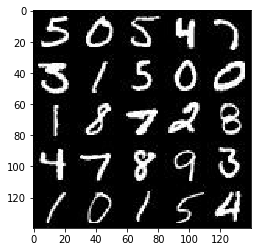

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

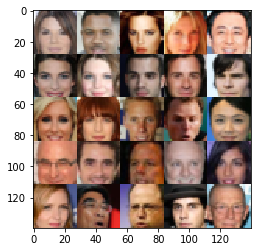

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        #input layer - if: RGB, 28x28x3, elif: Black-white, 28x28x2
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3) 
        # 4x4x256
        
        # Flattening it... 
        flat = tf.reshape(relu3, (-1, 4*4*256)) # Not sure of 4*4, it could e 3*3 too... 
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)      
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not(is_train)):
        
        # adding layers as large as the size of the input image
        h1 = tf.layers.dense(z, 7*7*512)
        
        # reshape it
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        # 7 x 7 x 512
        
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        # 14 x 14 x 256
        
        h3 = tf.layers.conv2d_transpose(h2, 512, 5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        # 28 x 28 x 512
        
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, strides=1, padding='same')
        # 28 x 28 x out_channel_dim
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.01, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g = generator(input_z, out_channel_dim, alpha=alpha)
    
    d_fake, d_fake_logits = discriminator(g, alpha=alpha)
    d_real, d_real_logits = discriminator(input_real, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits,
                                                                        labels=tf.ones_like(d_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,
                                                                        labels=tf.zeros_like(d_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,
                                                                        labels=tf.ones_like(d_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))

In [12]:
mnist_dataset.shape

(60000, 28, 28, 1)

In [13]:
celeba_dataset.shape

(202599, 28, 28, 3)

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1,
          get_batches, data_shape, data_image_mode, alpha=0.01, smooth=0.1,):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    # Set the data dimensions
    no_of_dataset = data_shape[0]
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    # Create the model
    inputs_real, inputs_z, l_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels, alpha, smooth)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    saver = tf.train.Saver()
    count = 0 # keeping the count to show generator output
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            print("epoch")
            for batch_images in get_batches(batch_size):  # get_batches contains the dataset
                # random noise for the generator
                #print(count)
                count = count + 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2
                # run the optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, l_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images, l_rate:learning_rate})
             
                if count % 10 == 0: # print every 10
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    print("Dataset processed {}/{}...".format(batch_size*count,no_of_dataset),
                              "Epoch {}/{}...".format(epoch_i, epoch_count),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))

                if count % 100 == 0: # every 100 batch
                    show_generator_output(sess, show_n_images, inputs_z, image_channels, data_image_mode)
        
        saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

epoch
Dataset processed 320/60000... Epoch 0/2... Discriminator Loss: 0.2181... Generator Loss: 9.9544
Dataset processed 640/60000... Epoch 0/2... Discriminator Loss: 0.2132... Generator Loss: 8.3995
Dataset processed 960/60000... Epoch 0/2... Discriminator Loss: 0.2804... Generator Loss: 7.9383
Dataset processed 1280/60000... Epoch 0/2... Discriminator Loss: 0.2433... Generator Loss: 8.6263
Dataset processed 1600/60000... Epoch 0/2... Discriminator Loss: 0.2197... Generator Loss: 9.9164
Dataset processed 1920/60000... Epoch 0/2... Discriminator Loss: 0.2772... Generator Loss: 8.8835
Dataset processed 2240/60000... Epoch 0/2... Discriminator Loss: 0.2040... Generator Loss: 9.0083
Dataset processed 2560/60000... Epoch 0/2... Discriminator Loss: 0.2257... Generator Loss: 9.2718
Dataset processed 2880/60000... Epoch 0/2... Discriminator Loss: 0.3293... Generator Loss: 2.7177
Dataset processed 3200/60000... Epoch 0/2... Discriminator Loss: 1.3646... Generator Loss: 0.8282


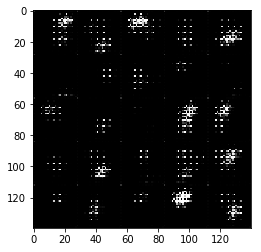

Dataset processed 3520/60000... Epoch 0/2... Discriminator Loss: 0.6354... Generator Loss: 1.7122
Dataset processed 3840/60000... Epoch 0/2... Discriminator Loss: 0.4698... Generator Loss: 4.8221
Dataset processed 4160/60000... Epoch 0/2... Discriminator Loss: 1.5970... Generator Loss: 0.6018
Dataset processed 4480/60000... Epoch 0/2... Discriminator Loss: 2.3773... Generator Loss: 0.1847
Dataset processed 4800/60000... Epoch 0/2... Discriminator Loss: 1.3927... Generator Loss: 0.4504
Dataset processed 5120/60000... Epoch 0/2... Discriminator Loss: 1.9762... Generator Loss: 0.2283
Dataset processed 5440/60000... Epoch 0/2... Discriminator Loss: 1.1210... Generator Loss: 0.9991
Dataset processed 5760/60000... Epoch 0/2... Discriminator Loss: 1.5715... Generator Loss: 0.3981
Dataset processed 6080/60000... Epoch 0/2... Discriminator Loss: 1.4991... Generator Loss: 0.4491
Dataset processed 6400/60000... Epoch 0/2... Discriminator Loss: 1.6422... Generator Loss: 0.3310


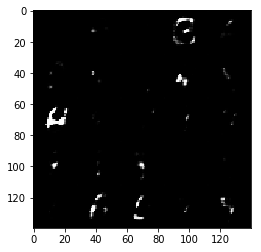

Dataset processed 6720/60000... Epoch 0/2... Discriminator Loss: 1.2911... Generator Loss: 0.4674
Dataset processed 7040/60000... Epoch 0/2... Discriminator Loss: 1.8283... Generator Loss: 0.2849
Dataset processed 7360/60000... Epoch 0/2... Discriminator Loss: 1.5081... Generator Loss: 0.4146
Dataset processed 7680/60000... Epoch 0/2... Discriminator Loss: 1.3708... Generator Loss: 0.4701
Dataset processed 8000/60000... Epoch 0/2... Discriminator Loss: 1.5421... Generator Loss: 2.4823
Dataset processed 8320/60000... Epoch 0/2... Discriminator Loss: 1.6210... Generator Loss: 0.3326
Dataset processed 8640/60000... Epoch 0/2... Discriminator Loss: 1.0790... Generator Loss: 0.6550
Dataset processed 8960/60000... Epoch 0/2... Discriminator Loss: 0.8662... Generator Loss: 1.1395
Dataset processed 9280/60000... Epoch 0/2... Discriminator Loss: 0.8213... Generator Loss: 0.9629
Dataset processed 9600/60000... Epoch 0/2... Discriminator Loss: 1.4481... Generator Loss: 0.4436


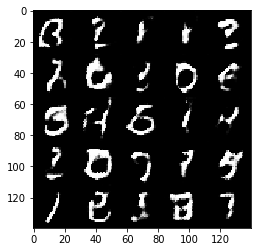

Dataset processed 9920/60000... Epoch 0/2... Discriminator Loss: 1.3260... Generator Loss: 1.6306
Dataset processed 10240/60000... Epoch 0/2... Discriminator Loss: 0.9695... Generator Loss: 0.8265
Dataset processed 10560/60000... Epoch 0/2... Discriminator Loss: 1.1881... Generator Loss: 0.5691
Dataset processed 10880/60000... Epoch 0/2... Discriminator Loss: 1.6791... Generator Loss: 0.3176
Dataset processed 11200/60000... Epoch 0/2... Discriminator Loss: 1.2396... Generator Loss: 0.6337
Dataset processed 11520/60000... Epoch 0/2... Discriminator Loss: 1.3439... Generator Loss: 0.5323
Dataset processed 11840/60000... Epoch 0/2... Discriminator Loss: 0.8701... Generator Loss: 0.9346
Dataset processed 12160/60000... Epoch 0/2... Discriminator Loss: 1.2747... Generator Loss: 1.2607
Dataset processed 12480/60000... Epoch 0/2... Discriminator Loss: 1.3162... Generator Loss: 0.7480
Dataset processed 12800/60000... Epoch 0/2... Discriminator Loss: 1.3054... Generator Loss: 1.2508


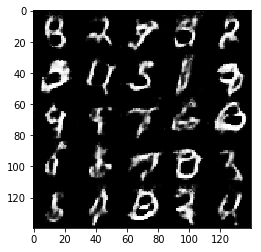

Dataset processed 13120/60000... Epoch 0/2... Discriminator Loss: 1.6095... Generator Loss: 0.3363
Dataset processed 13440/60000... Epoch 0/2... Discriminator Loss: 1.4155... Generator Loss: 0.5681
Dataset processed 13760/60000... Epoch 0/2... Discriminator Loss: 1.2069... Generator Loss: 0.6189
Dataset processed 14080/60000... Epoch 0/2... Discriminator Loss: 1.1795... Generator Loss: 0.6394
Dataset processed 14400/60000... Epoch 0/2... Discriminator Loss: 1.4275... Generator Loss: 0.4678
Dataset processed 14720/60000... Epoch 0/2... Discriminator Loss: 1.3701... Generator Loss: 0.6626
Dataset processed 15040/60000... Epoch 0/2... Discriminator Loss: 1.2391... Generator Loss: 1.1707
Dataset processed 15360/60000... Epoch 0/2... Discriminator Loss: 1.2938... Generator Loss: 1.4910
Dataset processed 15680/60000... Epoch 0/2... Discriminator Loss: 1.5672... Generator Loss: 0.3393
Dataset processed 16000/60000... Epoch 0/2... Discriminator Loss: 1.7668... Generator Loss: 0.2665


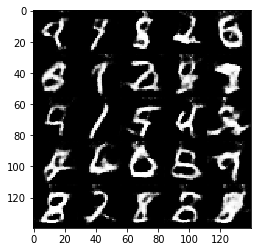

Dataset processed 16320/60000... Epoch 0/2... Discriminator Loss: 1.2754... Generator Loss: 0.6547
Dataset processed 16640/60000... Epoch 0/2... Discriminator Loss: 1.2766... Generator Loss: 0.6828
Dataset processed 16960/60000... Epoch 0/2... Discriminator Loss: 1.7292... Generator Loss: 0.2819
Dataset processed 17280/60000... Epoch 0/2... Discriminator Loss: 1.2271... Generator Loss: 0.5784
Dataset processed 17600/60000... Epoch 0/2... Discriminator Loss: 1.3895... Generator Loss: 0.4689
Dataset processed 17920/60000... Epoch 0/2... Discriminator Loss: 1.2139... Generator Loss: 1.4434
Dataset processed 18240/60000... Epoch 0/2... Discriminator Loss: 1.5316... Generator Loss: 0.3780
Dataset processed 18560/60000... Epoch 0/2... Discriminator Loss: 1.2539... Generator Loss: 0.5631
Dataset processed 18880/60000... Epoch 0/2... Discriminator Loss: 1.5643... Generator Loss: 0.3690
Dataset processed 19200/60000... Epoch 0/2... Discriminator Loss: 1.2920... Generator Loss: 0.5692


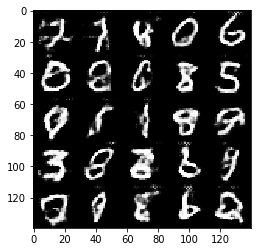

Dataset processed 19520/60000... Epoch 0/2... Discriminator Loss: 1.4335... Generator Loss: 0.4260
Dataset processed 19840/60000... Epoch 0/2... Discriminator Loss: 1.3843... Generator Loss: 0.4611
Dataset processed 20160/60000... Epoch 0/2... Discriminator Loss: 1.2254... Generator Loss: 1.3969
Dataset processed 20480/60000... Epoch 0/2... Discriminator Loss: 1.2858... Generator Loss: 1.3261
Dataset processed 20800/60000... Epoch 0/2... Discriminator Loss: 1.5387... Generator Loss: 0.3711
Dataset processed 21120/60000... Epoch 0/2... Discriminator Loss: 0.9500... Generator Loss: 1.4670
Dataset processed 21440/60000... Epoch 0/2... Discriminator Loss: 1.2453... Generator Loss: 0.7748
Dataset processed 21760/60000... Epoch 0/2... Discriminator Loss: 1.5170... Generator Loss: 0.3794
Dataset processed 22080/60000... Epoch 0/2... Discriminator Loss: 1.3143... Generator Loss: 0.6091
Dataset processed 22400/60000... Epoch 0/2... Discriminator Loss: 1.2706... Generator Loss: 0.4888


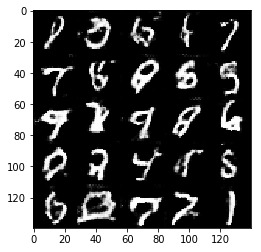

Dataset processed 22720/60000... Epoch 0/2... Discriminator Loss: 1.1896... Generator Loss: 0.6118
Dataset processed 23040/60000... Epoch 0/2... Discriminator Loss: 1.3821... Generator Loss: 0.4573
Dataset processed 23360/60000... Epoch 0/2... Discriminator Loss: 1.4384... Generator Loss: 0.4296
Dataset processed 23680/60000... Epoch 0/2... Discriminator Loss: 1.2504... Generator Loss: 0.5616
Dataset processed 24000/60000... Epoch 0/2... Discriminator Loss: 1.6119... Generator Loss: 0.3621
Dataset processed 24320/60000... Epoch 0/2... Discriminator Loss: 1.4830... Generator Loss: 0.4354
Dataset processed 24640/60000... Epoch 0/2... Discriminator Loss: 1.4995... Generator Loss: 0.3782
Dataset processed 24960/60000... Epoch 0/2... Discriminator Loss: 1.5527... Generator Loss: 0.3959
Dataset processed 25280/60000... Epoch 0/2... Discriminator Loss: 1.1425... Generator Loss: 0.8734
Dataset processed 25600/60000... Epoch 0/2... Discriminator Loss: 1.0222... Generator Loss: 1.2796


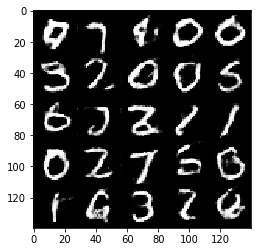

Dataset processed 25920/60000... Epoch 0/2... Discriminator Loss: 1.1327... Generator Loss: 0.9383
Dataset processed 26240/60000... Epoch 0/2... Discriminator Loss: 1.0380... Generator Loss: 1.1009
Dataset processed 26560/60000... Epoch 0/2... Discriminator Loss: 0.9729... Generator Loss: 1.0136
Dataset processed 26880/60000... Epoch 0/2... Discriminator Loss: 1.7838... Generator Loss: 0.2991
Dataset processed 27200/60000... Epoch 0/2... Discriminator Loss: 1.4245... Generator Loss: 0.4387
Dataset processed 27520/60000... Epoch 0/2... Discriminator Loss: 0.9847... Generator Loss: 0.9953
Dataset processed 27840/60000... Epoch 0/2... Discriminator Loss: 1.4343... Generator Loss: 0.4062
Dataset processed 28160/60000... Epoch 0/2... Discriminator Loss: 1.4822... Generator Loss: 0.4073
Dataset processed 28480/60000... Epoch 0/2... Discriminator Loss: 1.2404... Generator Loss: 0.5913
Dataset processed 28800/60000... Epoch 0/2... Discriminator Loss: 2.1943... Generator Loss: 0.1698


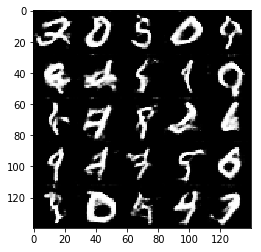

Dataset processed 29120/60000... Epoch 0/2... Discriminator Loss: 1.2389... Generator Loss: 0.5474
Dataset processed 29440/60000... Epoch 0/2... Discriminator Loss: 0.9950... Generator Loss: 1.2876
Dataset processed 29760/60000... Epoch 0/2... Discriminator Loss: 1.7533... Generator Loss: 0.3019
Dataset processed 30080/60000... Epoch 0/2... Discriminator Loss: 1.0605... Generator Loss: 0.8210
Dataset processed 30400/60000... Epoch 0/2... Discriminator Loss: 1.1182... Generator Loss: 1.2414
Dataset processed 30720/60000... Epoch 0/2... Discriminator Loss: 0.8430... Generator Loss: 1.0460
Dataset processed 31040/60000... Epoch 0/2... Discriminator Loss: 1.0223... Generator Loss: 0.7646
Dataset processed 31360/60000... Epoch 0/2... Discriminator Loss: 0.9896... Generator Loss: 0.9220
Dataset processed 31680/60000... Epoch 0/2... Discriminator Loss: 1.2044... Generator Loss: 0.5979
Dataset processed 32000/60000... Epoch 0/2... Discriminator Loss: 0.9692... Generator Loss: 1.0691


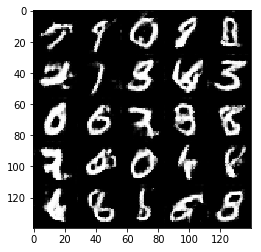

Dataset processed 32320/60000... Epoch 0/2... Discriminator Loss: 1.2827... Generator Loss: 1.6502
Dataset processed 32640/60000... Epoch 0/2... Discriminator Loss: 1.1198... Generator Loss: 0.8413
Dataset processed 32960/60000... Epoch 0/2... Discriminator Loss: 1.0211... Generator Loss: 1.3802
Dataset processed 33280/60000... Epoch 0/2... Discriminator Loss: 1.3854... Generator Loss: 1.7444
Dataset processed 33600/60000... Epoch 0/2... Discriminator Loss: 1.2616... Generator Loss: 0.6370
Dataset processed 33920/60000... Epoch 0/2... Discriminator Loss: 0.9548... Generator Loss: 1.5236
Dataset processed 34240/60000... Epoch 0/2... Discriminator Loss: 0.9649... Generator Loss: 1.0559
Dataset processed 34560/60000... Epoch 0/2... Discriminator Loss: 1.6228... Generator Loss: 0.3654
Dataset processed 34880/60000... Epoch 0/2... Discriminator Loss: 1.2397... Generator Loss: 0.6072
Dataset processed 35200/60000... Epoch 0/2... Discriminator Loss: 0.9114... Generator Loss: 0.9138


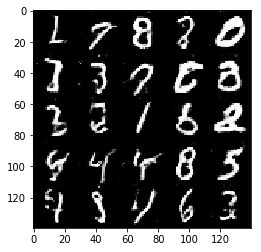

Dataset processed 35520/60000... Epoch 0/2... Discriminator Loss: 2.2109... Generator Loss: 0.2539
Dataset processed 35840/60000... Epoch 0/2... Discriminator Loss: 1.1806... Generator Loss: 0.6529
Dataset processed 36160/60000... Epoch 0/2... Discriminator Loss: 1.4912... Generator Loss: 0.4318
Dataset processed 36480/60000... Epoch 0/2... Discriminator Loss: 0.9840... Generator Loss: 1.6247
Dataset processed 36800/60000... Epoch 0/2... Discriminator Loss: 1.0603... Generator Loss: 1.0812
Dataset processed 37120/60000... Epoch 0/2... Discriminator Loss: 1.0983... Generator Loss: 2.0177
Dataset processed 37440/60000... Epoch 0/2... Discriminator Loss: 1.5706... Generator Loss: 0.3842
Dataset processed 37760/60000... Epoch 0/2... Discriminator Loss: 1.4270... Generator Loss: 0.4237
Dataset processed 38080/60000... Epoch 0/2... Discriminator Loss: 0.9063... Generator Loss: 1.1854
Dataset processed 38400/60000... Epoch 0/2... Discriminator Loss: 1.2574... Generator Loss: 1.3856


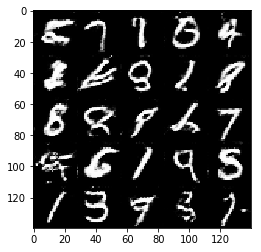

Dataset processed 38720/60000... Epoch 0/2... Discriminator Loss: 1.0376... Generator Loss: 0.8340
Dataset processed 39040/60000... Epoch 0/2... Discriminator Loss: 1.4610... Generator Loss: 0.4387
Dataset processed 39360/60000... Epoch 0/2... Discriminator Loss: 0.9564... Generator Loss: 1.3100
Dataset processed 39680/60000... Epoch 0/2... Discriminator Loss: 1.1938... Generator Loss: 0.7368
Dataset processed 40000/60000... Epoch 0/2... Discriminator Loss: 1.1455... Generator Loss: 0.6500
Dataset processed 40320/60000... Epoch 0/2... Discriminator Loss: 1.1397... Generator Loss: 0.6332
Dataset processed 40640/60000... Epoch 0/2... Discriminator Loss: 1.1948... Generator Loss: 0.7018
Dataset processed 40960/60000... Epoch 0/2... Discriminator Loss: 1.3063... Generator Loss: 0.4969
Dataset processed 41280/60000... Epoch 0/2... Discriminator Loss: 1.4177... Generator Loss: 0.4497
Dataset processed 41600/60000... Epoch 0/2... Discriminator Loss: 1.3782... Generator Loss: 0.4605


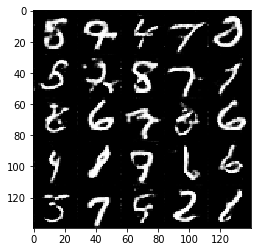

Dataset processed 41920/60000... Epoch 0/2... Discriminator Loss: 1.1856... Generator Loss: 0.8740
Dataset processed 42240/60000... Epoch 0/2... Discriminator Loss: 1.0337... Generator Loss: 1.9874
Dataset processed 42560/60000... Epoch 0/2... Discriminator Loss: 1.2615... Generator Loss: 0.6490
Dataset processed 42880/60000... Epoch 0/2... Discriminator Loss: 1.1793... Generator Loss: 1.3271
Dataset processed 43200/60000... Epoch 0/2... Discriminator Loss: 1.2115... Generator Loss: 0.5933
Dataset processed 43520/60000... Epoch 0/2... Discriminator Loss: 1.1429... Generator Loss: 0.6185
Dataset processed 43840/60000... Epoch 0/2... Discriminator Loss: 0.8952... Generator Loss: 1.2320
Dataset processed 44160/60000... Epoch 0/2... Discriminator Loss: 1.7126... Generator Loss: 0.2822
Dataset processed 44480/60000... Epoch 0/2... Discriminator Loss: 0.8398... Generator Loss: 1.0540
Dataset processed 44800/60000... Epoch 0/2... Discriminator Loss: 0.9670... Generator Loss: 1.2231


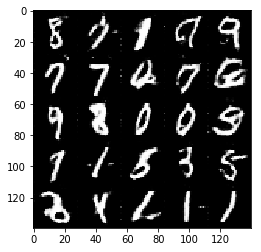

Dataset processed 45120/60000... Epoch 0/2... Discriminator Loss: 0.9952... Generator Loss: 0.9312
Dataset processed 45440/60000... Epoch 0/2... Discriminator Loss: 1.4354... Generator Loss: 0.3964
Dataset processed 45760/60000... Epoch 0/2... Discriminator Loss: 1.5008... Generator Loss: 0.3692
Dataset processed 46080/60000... Epoch 0/2... Discriminator Loss: 2.0267... Generator Loss: 0.2287
Dataset processed 46400/60000... Epoch 0/2... Discriminator Loss: 1.2002... Generator Loss: 0.6494
Dataset processed 46720/60000... Epoch 0/2... Discriminator Loss: 0.8048... Generator Loss: 1.0341
Dataset processed 47040/60000... Epoch 0/2... Discriminator Loss: 0.8669... Generator Loss: 0.9802
Dataset processed 47360/60000... Epoch 0/2... Discriminator Loss: 1.1542... Generator Loss: 0.6623
Dataset processed 47680/60000... Epoch 0/2... Discriminator Loss: 1.0511... Generator Loss: 1.2217
Dataset processed 48000/60000... Epoch 0/2... Discriminator Loss: 1.1057... Generator Loss: 0.6807


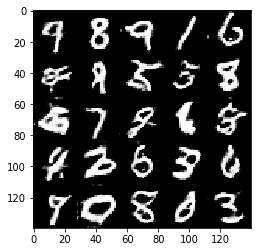

Dataset processed 48320/60000... Epoch 0/2... Discriminator Loss: 1.6144... Generator Loss: 0.3233
Dataset processed 48640/60000... Epoch 0/2... Discriminator Loss: 1.0165... Generator Loss: 1.3579
Dataset processed 48960/60000... Epoch 0/2... Discriminator Loss: 0.7619... Generator Loss: 1.8084
Dataset processed 49280/60000... Epoch 0/2... Discriminator Loss: 0.9064... Generator Loss: 1.4016
Dataset processed 49600/60000... Epoch 0/2... Discriminator Loss: 0.7599... Generator Loss: 1.1453
Dataset processed 49920/60000... Epoch 0/2... Discriminator Loss: 1.7947... Generator Loss: 2.6654
Dataset processed 50240/60000... Epoch 0/2... Discriminator Loss: 1.1683... Generator Loss: 1.0624
Dataset processed 50560/60000... Epoch 0/2... Discriminator Loss: 0.9490... Generator Loss: 1.5922
Dataset processed 50880/60000... Epoch 0/2... Discriminator Loss: 1.0862... Generator Loss: 0.7724
Dataset processed 51200/60000... Epoch 0/2... Discriminator Loss: 0.9759... Generator Loss: 1.3948


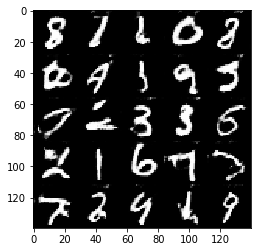

Dataset processed 51520/60000... Epoch 0/2... Discriminator Loss: 1.0218... Generator Loss: 0.9858
Dataset processed 51840/60000... Epoch 0/2... Discriminator Loss: 1.5893... Generator Loss: 0.3417
Dataset processed 52160/60000... Epoch 0/2... Discriminator Loss: 0.9218... Generator Loss: 1.5881
Dataset processed 52480/60000... Epoch 0/2... Discriminator Loss: 1.0789... Generator Loss: 1.4773
Dataset processed 52800/60000... Epoch 0/2... Discriminator Loss: 1.1749... Generator Loss: 0.6169
Dataset processed 53120/60000... Epoch 0/2... Discriminator Loss: 0.6967... Generator Loss: 1.3542
Dataset processed 53440/60000... Epoch 0/2... Discriminator Loss: 1.7464... Generator Loss: 0.3570
Dataset processed 53760/60000... Epoch 0/2... Discriminator Loss: 1.5016... Generator Loss: 0.3969
Dataset processed 54080/60000... Epoch 0/2... Discriminator Loss: 1.0460... Generator Loss: 1.8714
Dataset processed 54400/60000... Epoch 0/2... Discriminator Loss: 1.3118... Generator Loss: 0.4890


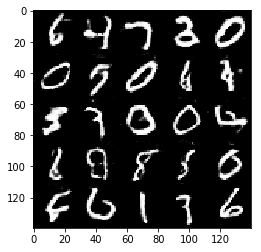

Dataset processed 54720/60000... Epoch 0/2... Discriminator Loss: 1.7608... Generator Loss: 0.3135
Dataset processed 55040/60000... Epoch 0/2... Discriminator Loss: 1.3000... Generator Loss: 2.1399
Dataset processed 55360/60000... Epoch 0/2... Discriminator Loss: 0.6915... Generator Loss: 1.6507
Dataset processed 55680/60000... Epoch 0/2... Discriminator Loss: 1.2736... Generator Loss: 0.5493
Dataset processed 56000/60000... Epoch 0/2... Discriminator Loss: 1.0367... Generator Loss: 1.6192
Dataset processed 56320/60000... Epoch 0/2... Discriminator Loss: 0.8968... Generator Loss: 1.8458
Dataset processed 56640/60000... Epoch 0/2... Discriminator Loss: 0.7238... Generator Loss: 1.1248
Dataset processed 56960/60000... Epoch 0/2... Discriminator Loss: 0.7651... Generator Loss: 1.1607
Dataset processed 57280/60000... Epoch 0/2... Discriminator Loss: 0.8347... Generator Loss: 1.5314
Dataset processed 57600/60000... Epoch 0/2... Discriminator Loss: 1.2998... Generator Loss: 0.4965


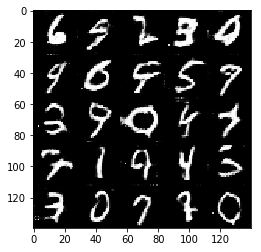

Dataset processed 57920/60000... Epoch 0/2... Discriminator Loss: 1.1857... Generator Loss: 0.7528
Dataset processed 58240/60000... Epoch 0/2... Discriminator Loss: 0.7225... Generator Loss: 1.3768
Dataset processed 58560/60000... Epoch 0/2... Discriminator Loss: 0.9410... Generator Loss: 1.2293
Dataset processed 58880/60000... Epoch 0/2... Discriminator Loss: 1.1459... Generator Loss: 0.6580
Dataset processed 59200/60000... Epoch 0/2... Discriminator Loss: 0.8725... Generator Loss: 1.2363
Dataset processed 59520/60000... Epoch 0/2... Discriminator Loss: 1.2733... Generator Loss: 0.5967
Dataset processed 59840/60000... Epoch 0/2... Discriminator Loss: 0.9398... Generator Loss: 1.7608
epoch
Dataset processed 60160/60000... Epoch 1/2... Discriminator Loss: 1.4597... Generator Loss: 0.4113
Dataset processed 60480/60000... Epoch 1/2... Discriminator Loss: 1.4474... Generator Loss: 0.4350
Dataset processed 60800/60000... Epoch 1/2... Discriminator Loss: 0.9177... Generator Loss: 1.1196


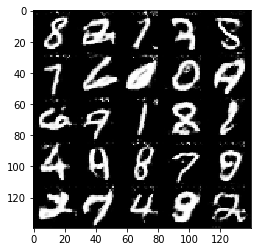

Dataset processed 61120/60000... Epoch 1/2... Discriminator Loss: 0.6755... Generator Loss: 1.2846
Dataset processed 61440/60000... Epoch 1/2... Discriminator Loss: 1.2788... Generator Loss: 2.3447
Dataset processed 61760/60000... Epoch 1/2... Discriminator Loss: 1.4113... Generator Loss: 0.4571
Dataset processed 62080/60000... Epoch 1/2... Discriminator Loss: 1.3116... Generator Loss: 0.5461
Dataset processed 62400/60000... Epoch 1/2... Discriminator Loss: 0.9566... Generator Loss: 0.8909
Dataset processed 62720/60000... Epoch 1/2... Discriminator Loss: 1.0139... Generator Loss: 0.6923
Dataset processed 63040/60000... Epoch 1/2... Discriminator Loss: 0.6994... Generator Loss: 1.3255
Dataset processed 63360/60000... Epoch 1/2... Discriminator Loss: 2.2311... Generator Loss: 0.1947
Dataset processed 63680/60000... Epoch 1/2... Discriminator Loss: 0.8005... Generator Loss: 1.4369
Dataset processed 64000/60000... Epoch 1/2... Discriminator Loss: 0.8454... Generator Loss: 1.8968


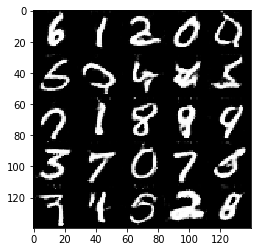

Dataset processed 64320/60000... Epoch 1/2... Discriminator Loss: 0.7523... Generator Loss: 1.2976
Dataset processed 64640/60000... Epoch 1/2... Discriminator Loss: 1.0126... Generator Loss: 1.5758
Dataset processed 64960/60000... Epoch 1/2... Discriminator Loss: 1.0093... Generator Loss: 0.8808
Dataset processed 65280/60000... Epoch 1/2... Discriminator Loss: 0.8145... Generator Loss: 1.5876
Dataset processed 65600/60000... Epoch 1/2... Discriminator Loss: 1.1546... Generator Loss: 0.5587
Dataset processed 65920/60000... Epoch 1/2... Discriminator Loss: 0.8796... Generator Loss: 0.9146
Dataset processed 66240/60000... Epoch 1/2... Discriminator Loss: 0.8352... Generator Loss: 1.0445
Dataset processed 66560/60000... Epoch 1/2... Discriminator Loss: 0.9381... Generator Loss: 1.0397
Dataset processed 66880/60000... Epoch 1/2... Discriminator Loss: 0.8456... Generator Loss: 1.6956
Dataset processed 67200/60000... Epoch 1/2... Discriminator Loss: 1.2680... Generator Loss: 2.0214


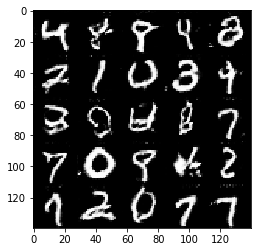

Dataset processed 67520/60000... Epoch 1/2... Discriminator Loss: 0.8768... Generator Loss: 1.4298
Dataset processed 67840/60000... Epoch 1/2... Discriminator Loss: 0.7683... Generator Loss: 1.2945
Dataset processed 68160/60000... Epoch 1/2... Discriminator Loss: 0.8318... Generator Loss: 1.2091
Dataset processed 68480/60000... Epoch 1/2... Discriminator Loss: 0.8271... Generator Loss: 1.0187
Dataset processed 68800/60000... Epoch 1/2... Discriminator Loss: 0.7425... Generator Loss: 1.4370
Dataset processed 69120/60000... Epoch 1/2... Discriminator Loss: 1.8529... Generator Loss: 0.3331
Dataset processed 69440/60000... Epoch 1/2... Discriminator Loss: 1.1520... Generator Loss: 0.6284
Dataset processed 69760/60000... Epoch 1/2... Discriminator Loss: 1.5802... Generator Loss: 0.3985
Dataset processed 70080/60000... Epoch 1/2... Discriminator Loss: 1.5373... Generator Loss: 0.3943
Dataset processed 70400/60000... Epoch 1/2... Discriminator Loss: 0.8205... Generator Loss: 0.9653


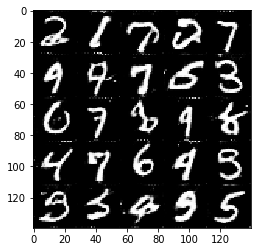

Dataset processed 70720/60000... Epoch 1/2... Discriminator Loss: 0.5900... Generator Loss: 1.8661
Dataset processed 71040/60000... Epoch 1/2... Discriminator Loss: 0.9843... Generator Loss: 0.7848
Dataset processed 71360/60000... Epoch 1/2... Discriminator Loss: 1.3081... Generator Loss: 0.4909
Dataset processed 71680/60000... Epoch 1/2... Discriminator Loss: 0.6658... Generator Loss: 1.6449
Dataset processed 72000/60000... Epoch 1/2... Discriminator Loss: 0.7899... Generator Loss: 1.0065
Dataset processed 72320/60000... Epoch 1/2... Discriminator Loss: 1.8869... Generator Loss: 0.2485
Dataset processed 72640/60000... Epoch 1/2... Discriminator Loss: 1.2762... Generator Loss: 0.5500
Dataset processed 72960/60000... Epoch 1/2... Discriminator Loss: 1.5880... Generator Loss: 0.3843
Dataset processed 73280/60000... Epoch 1/2... Discriminator Loss: 0.7999... Generator Loss: 1.1342
Dataset processed 73600/60000... Epoch 1/2... Discriminator Loss: 3.1648... Generator Loss: 0.1157


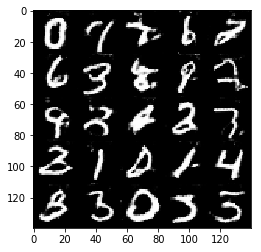

Dataset processed 73920/60000... Epoch 1/2... Discriminator Loss: 1.1688... Generator Loss: 0.6135
Dataset processed 74240/60000... Epoch 1/2... Discriminator Loss: 1.0674... Generator Loss: 0.6918
Dataset processed 74560/60000... Epoch 1/2... Discriminator Loss: 1.5943... Generator Loss: 0.4074
Dataset processed 74880/60000... Epoch 1/2... Discriminator Loss: 1.3389... Generator Loss: 0.5339
Dataset processed 75200/60000... Epoch 1/2... Discriminator Loss: 0.7569... Generator Loss: 1.6353
Dataset processed 75520/60000... Epoch 1/2... Discriminator Loss: 1.1077... Generator Loss: 0.6400
Dataset processed 75840/60000... Epoch 1/2... Discriminator Loss: 0.6739... Generator Loss: 1.4530
Dataset processed 76160/60000... Epoch 1/2... Discriminator Loss: 1.2209... Generator Loss: 0.5922
Dataset processed 76480/60000... Epoch 1/2... Discriminator Loss: 0.8632... Generator Loss: 0.8934
Dataset processed 76800/60000... Epoch 1/2... Discriminator Loss: 0.8038... Generator Loss: 1.0671


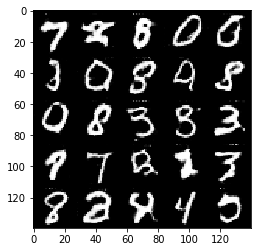

Dataset processed 77120/60000... Epoch 1/2... Discriminator Loss: 1.2523... Generator Loss: 1.9022
Dataset processed 77440/60000... Epoch 1/2... Discriminator Loss: 0.8420... Generator Loss: 1.3670
Dataset processed 77760/60000... Epoch 1/2... Discriminator Loss: 1.1719... Generator Loss: 0.6654
Dataset processed 78080/60000... Epoch 1/2... Discriminator Loss: 1.1695... Generator Loss: 4.1232
Dataset processed 78400/60000... Epoch 1/2... Discriminator Loss: 0.9386... Generator Loss: 0.9614
Dataset processed 78720/60000... Epoch 1/2... Discriminator Loss: 1.2526... Generator Loss: 0.5642
Dataset processed 79040/60000... Epoch 1/2... Discriminator Loss: 0.5334... Generator Loss: 1.9189
Dataset processed 79360/60000... Epoch 1/2... Discriminator Loss: 0.6506... Generator Loss: 2.2715
Dataset processed 79680/60000... Epoch 1/2... Discriminator Loss: 1.0226... Generator Loss: 1.9295
Dataset processed 80000/60000... Epoch 1/2... Discriminator Loss: 0.6663... Generator Loss: 2.0347


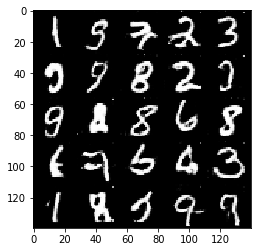

Dataset processed 80320/60000... Epoch 1/2... Discriminator Loss: 1.4377... Generator Loss: 0.4423
Dataset processed 80640/60000... Epoch 1/2... Discriminator Loss: 0.6672... Generator Loss: 1.3965
Dataset processed 80960/60000... Epoch 1/2... Discriminator Loss: 0.7051... Generator Loss: 1.3974
Dataset processed 81280/60000... Epoch 1/2... Discriminator Loss: 0.7972... Generator Loss: 1.0697
Dataset processed 81600/60000... Epoch 1/2... Discriminator Loss: 1.0542... Generator Loss: 0.7246
Dataset processed 81920/60000... Epoch 1/2... Discriminator Loss: 0.8151... Generator Loss: 1.1818
Dataset processed 82240/60000... Epoch 1/2... Discriminator Loss: 1.7724... Generator Loss: 0.2955
Dataset processed 82560/60000... Epoch 1/2... Discriminator Loss: 0.6780... Generator Loss: 2.1785
Dataset processed 82880/60000... Epoch 1/2... Discriminator Loss: 0.5102... Generator Loss: 2.1363
Dataset processed 83200/60000... Epoch 1/2... Discriminator Loss: 1.4979... Generator Loss: 0.4745


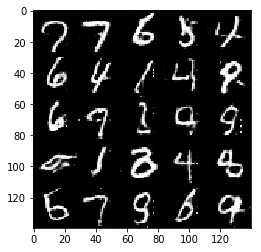

Dataset processed 83520/60000... Epoch 1/2... Discriminator Loss: 0.6603... Generator Loss: 1.2598
Dataset processed 83840/60000... Epoch 1/2... Discriminator Loss: 0.4331... Generator Loss: 2.2396
Dataset processed 84160/60000... Epoch 1/2... Discriminator Loss: 1.0555... Generator Loss: 0.6811
Dataset processed 84480/60000... Epoch 1/2... Discriminator Loss: 0.5553... Generator Loss: 2.1580
Dataset processed 84800/60000... Epoch 1/2... Discriminator Loss: 0.8888... Generator Loss: 0.8996
Dataset processed 85120/60000... Epoch 1/2... Discriminator Loss: 0.6460... Generator Loss: 1.2219
Dataset processed 85440/60000... Epoch 1/2... Discriminator Loss: 1.4274... Generator Loss: 3.3689
Dataset processed 85760/60000... Epoch 1/2... Discriminator Loss: 0.6115... Generator Loss: 1.4926
Dataset processed 86080/60000... Epoch 1/2... Discriminator Loss: 0.5329... Generator Loss: 1.7326
Dataset processed 86400/60000... Epoch 1/2... Discriminator Loss: 1.7284... Generator Loss: 0.3801


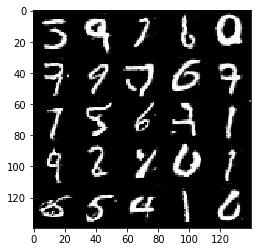

Dataset processed 86720/60000... Epoch 1/2... Discriminator Loss: 0.6354... Generator Loss: 1.4562
Dataset processed 87040/60000... Epoch 1/2... Discriminator Loss: 0.5300... Generator Loss: 1.7609
Dataset processed 87360/60000... Epoch 1/2... Discriminator Loss: 1.1557... Generator Loss: 0.8476
Dataset processed 87680/60000... Epoch 1/2... Discriminator Loss: 0.5010... Generator Loss: 2.1195
Dataset processed 88000/60000... Epoch 1/2... Discriminator Loss: 0.4480... Generator Loss: 2.0171
Dataset processed 88320/60000... Epoch 1/2... Discriminator Loss: 0.8235... Generator Loss: 3.0025
Dataset processed 88640/60000... Epoch 1/2... Discriminator Loss: 0.9837... Generator Loss: 1.8585
Dataset processed 88960/60000... Epoch 1/2... Discriminator Loss: 0.8571... Generator Loss: 0.9144
Dataset processed 89280/60000... Epoch 1/2... Discriminator Loss: 0.7114... Generator Loss: 1.2479
Dataset processed 89600/60000... Epoch 1/2... Discriminator Loss: 1.1743... Generator Loss: 0.5938


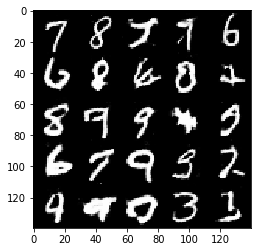

Dataset processed 89920/60000... Epoch 1/2... Discriminator Loss: 0.7245... Generator Loss: 2.3825
Dataset processed 90240/60000... Epoch 1/2... Discriminator Loss: 0.7735... Generator Loss: 1.2351
Dataset processed 90560/60000... Epoch 1/2... Discriminator Loss: 0.7335... Generator Loss: 1.1935
Dataset processed 90880/60000... Epoch 1/2... Discriminator Loss: 0.5614... Generator Loss: 1.6871
Dataset processed 91200/60000... Epoch 1/2... Discriminator Loss: 0.6609... Generator Loss: 1.2583
Dataset processed 91520/60000... Epoch 1/2... Discriminator Loss: 2.8878... Generator Loss: 5.3810
Dataset processed 91840/60000... Epoch 1/2... Discriminator Loss: 0.6405... Generator Loss: 1.6418
Dataset processed 92160/60000... Epoch 1/2... Discriminator Loss: 0.7109... Generator Loss: 1.1556
Dataset processed 92480/60000... Epoch 1/2... Discriminator Loss: 0.7568... Generator Loss: 2.5964
Dataset processed 92800/60000... Epoch 1/2... Discriminator Loss: 0.6046... Generator Loss: 1.4269


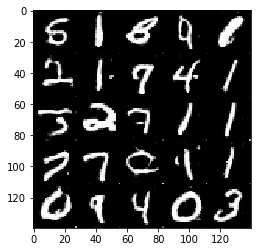

Dataset processed 93120/60000... Epoch 1/2... Discriminator Loss: 1.1869... Generator Loss: 0.5881
Dataset processed 93440/60000... Epoch 1/2... Discriminator Loss: 0.5171... Generator Loss: 1.5633
Dataset processed 93760/60000... Epoch 1/2... Discriminator Loss: 0.4984... Generator Loss: 1.7495
Dataset processed 94080/60000... Epoch 1/2... Discriminator Loss: 0.7026... Generator Loss: 1.7491
Dataset processed 94400/60000... Epoch 1/2... Discriminator Loss: 0.8476... Generator Loss: 2.4634
Dataset processed 94720/60000... Epoch 1/2... Discriminator Loss: 0.6599... Generator Loss: 1.7888
Dataset processed 95040/60000... Epoch 1/2... Discriminator Loss: 0.4624... Generator Loss: 1.9211
Dataset processed 95360/60000... Epoch 1/2... Discriminator Loss: 0.4569... Generator Loss: 2.3237
Dataset processed 95680/60000... Epoch 1/2... Discriminator Loss: 1.4208... Generator Loss: 0.4575
Dataset processed 96000/60000... Epoch 1/2... Discriminator Loss: 1.1145... Generator Loss: 0.7011


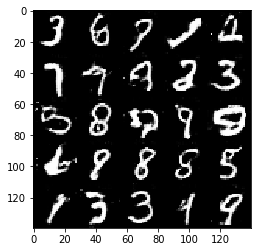

Dataset processed 96320/60000... Epoch 1/2... Discriminator Loss: 0.8010... Generator Loss: 1.1411
Dataset processed 96640/60000... Epoch 1/2... Discriminator Loss: 1.4056... Generator Loss: 0.5701
Dataset processed 96960/60000... Epoch 1/2... Discriminator Loss: 0.9844... Generator Loss: 0.7900
Dataset processed 97280/60000... Epoch 1/2... Discriminator Loss: 0.6603... Generator Loss: 1.4639
Dataset processed 97600/60000... Epoch 1/2... Discriminator Loss: 0.5946... Generator Loss: 2.0207
Dataset processed 97920/60000... Epoch 1/2... Discriminator Loss: 0.4834... Generator Loss: 1.9932
Dataset processed 98240/60000... Epoch 1/2... Discriminator Loss: 1.1069... Generator Loss: 0.7645
Dataset processed 98560/60000... Epoch 1/2... Discriminator Loss: 1.8297... Generator Loss: 0.3377
Dataset processed 98880/60000... Epoch 1/2... Discriminator Loss: 0.5336... Generator Loss: 1.5611
Dataset processed 99200/60000... Epoch 1/2... Discriminator Loss: 0.6747... Generator Loss: 1.6961


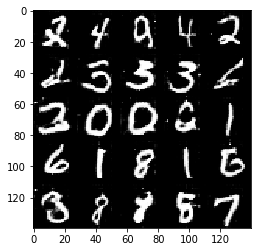

Dataset processed 99520/60000... Epoch 1/2... Discriminator Loss: 0.5688... Generator Loss: 1.7655
Dataset processed 99840/60000... Epoch 1/2... Discriminator Loss: 1.0468... Generator Loss: 0.8005
Dataset processed 100160/60000... Epoch 1/2... Discriminator Loss: 1.6484... Generator Loss: 0.4485
Dataset processed 100480/60000... Epoch 1/2... Discriminator Loss: 0.5272... Generator Loss: 1.8923
Dataset processed 100800/60000... Epoch 1/2... Discriminator Loss: 0.4600... Generator Loss: 1.9892
Dataset processed 101120/60000... Epoch 1/2... Discriminator Loss: 1.1008... Generator Loss: 2.6811
Dataset processed 101440/60000... Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 0.6809
Dataset processed 101760/60000... Epoch 1/2... Discriminator Loss: 0.5434... Generator Loss: 2.2126
Dataset processed 102080/60000... Epoch 1/2... Discriminator Loss: 0.5214... Generator Loss: 2.1489
Dataset processed 102400/60000... Epoch 1/2... Discriminator Loss: 0.4544... Generator Loss: 3.0564


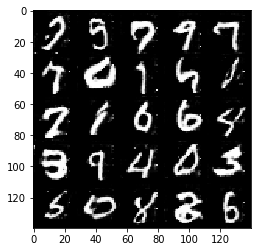

Dataset processed 102720/60000... Epoch 1/2... Discriminator Loss: 0.7169... Generator Loss: 1.4074
Dataset processed 103040/60000... Epoch 1/2... Discriminator Loss: 0.5265... Generator Loss: 2.4462
Dataset processed 103360/60000... Epoch 1/2... Discriminator Loss: 0.5107... Generator Loss: 1.9610
Dataset processed 103680/60000... Epoch 1/2... Discriminator Loss: 0.5722... Generator Loss: 2.0866
Dataset processed 104000/60000... Epoch 1/2... Discriminator Loss: 0.4254... Generator Loss: 2.1184
Dataset processed 104320/60000... Epoch 1/2... Discriminator Loss: 1.2814... Generator Loss: 3.0813
Dataset processed 104640/60000... Epoch 1/2... Discriminator Loss: 0.6792... Generator Loss: 1.4857
Dataset processed 104960/60000... Epoch 1/2... Discriminator Loss: 0.7615... Generator Loss: 2.9103
Dataset processed 105280/60000... Epoch 1/2... Discriminator Loss: 0.4981... Generator Loss: 2.0901
Dataset processed 105600/60000... Epoch 1/2... Discriminator Loss: 1.1163... Generator Loss: 0.7923


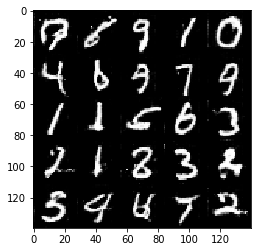

Dataset processed 105920/60000... Epoch 1/2... Discriminator Loss: 0.7103... Generator Loss: 1.1750
Dataset processed 106240/60000... Epoch 1/2... Discriminator Loss: 0.4808... Generator Loss: 1.9171
Dataset processed 106560/60000... Epoch 1/2... Discriminator Loss: 0.9029... Generator Loss: 0.8916
Dataset processed 106880/60000... Epoch 1/2... Discriminator Loss: 0.7136... Generator Loss: 1.4891
Dataset processed 107200/60000... Epoch 1/2... Discriminator Loss: 0.6523... Generator Loss: 1.6274
Dataset processed 107520/60000... Epoch 1/2... Discriminator Loss: 0.4581... Generator Loss: 3.3701
Dataset processed 107840/60000... Epoch 1/2... Discriminator Loss: 1.1278... Generator Loss: 0.8241
Dataset processed 108160/60000... Epoch 1/2... Discriminator Loss: 0.7918... Generator Loss: 2.6288
Dataset processed 108480/60000... Epoch 1/2... Discriminator Loss: 1.0848... Generator Loss: 2.7257
Dataset processed 108800/60000... Epoch 1/2... Discriminator Loss: 0.6823... Generator Loss: 1.1965


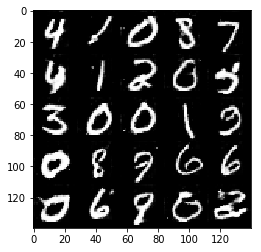

Dataset processed 109120/60000... Epoch 1/2... Discriminator Loss: 0.8626... Generator Loss: 1.1150
Dataset processed 109440/60000... Epoch 1/2... Discriminator Loss: 0.8552... Generator Loss: 2.4618
Dataset processed 109760/60000... Epoch 1/2... Discriminator Loss: 1.2553... Generator Loss: 0.5650
Dataset processed 110080/60000... Epoch 1/2... Discriminator Loss: 0.4254... Generator Loss: 2.3992
Dataset processed 110400/60000... Epoch 1/2... Discriminator Loss: 0.9323... Generator Loss: 0.9353
Dataset processed 110720/60000... Epoch 1/2... Discriminator Loss: 1.2738... Generator Loss: 0.5831
Dataset processed 111040/60000... Epoch 1/2... Discriminator Loss: 0.7383... Generator Loss: 2.9936
Dataset processed 111360/60000... Epoch 1/2... Discriminator Loss: 0.5579... Generator Loss: 1.8387
Dataset processed 111680/60000... Epoch 1/2... Discriminator Loss: 0.5839... Generator Loss: 1.5812
Dataset processed 112000/60000... Epoch 1/2... Discriminator Loss: 1.3976... Generator Loss: 3.3409


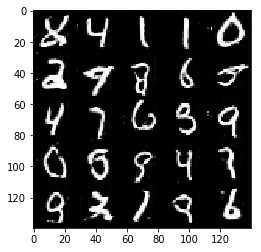

Dataset processed 112320/60000... Epoch 1/2... Discriminator Loss: 0.5244... Generator Loss: 1.8278
Dataset processed 112640/60000... Epoch 1/2... Discriminator Loss: 0.6621... Generator Loss: 2.5704
Dataset processed 112960/60000... Epoch 1/2... Discriminator Loss: 0.9351... Generator Loss: 3.0199
Dataset processed 113280/60000... Epoch 1/2... Discriminator Loss: 0.5318... Generator Loss: 1.5312
Dataset processed 113600/60000... Epoch 1/2... Discriminator Loss: 0.6687... Generator Loss: 1.3527
Dataset processed 113920/60000... Epoch 1/2... Discriminator Loss: 0.6091... Generator Loss: 1.4941
Dataset processed 114240/60000... Epoch 1/2... Discriminator Loss: 1.0685... Generator Loss: 0.7687
Dataset processed 114560/60000... Epoch 1/2... Discriminator Loss: 0.7088... Generator Loss: 1.4266
Dataset processed 114880/60000... Epoch 1/2... Discriminator Loss: 0.6506... Generator Loss: 1.5796
Dataset processed 115200/60000... Epoch 1/2... Discriminator Loss: 0.2741... Generator Loss: 3.5319


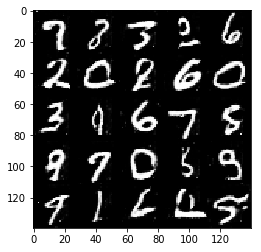

Dataset processed 115520/60000... Epoch 1/2... Discriminator Loss: 0.8863... Generator Loss: 0.9516
Dataset processed 115840/60000... Epoch 1/2... Discriminator Loss: 0.7420... Generator Loss: 1.2880
Dataset processed 116160/60000... Epoch 1/2... Discriminator Loss: 0.6238... Generator Loss: 1.3675
Dataset processed 116480/60000... Epoch 1/2... Discriminator Loss: 0.4558... Generator Loss: 1.9282
Dataset processed 116800/60000... Epoch 1/2... Discriminator Loss: 0.5801... Generator Loss: 1.6836
Dataset processed 117120/60000... Epoch 1/2... Discriminator Loss: 0.4218... Generator Loss: 2.0841
Dataset processed 117440/60000... Epoch 1/2... Discriminator Loss: 1.2699... Generator Loss: 0.6214
Dataset processed 117760/60000... Epoch 1/2... Discriminator Loss: 0.8432... Generator Loss: 1.4495
Dataset processed 118080/60000... Epoch 1/2... Discriminator Loss: 0.4314... Generator Loss: 1.9185
Dataset processed 118400/60000... Epoch 1/2... Discriminator Loss: 1.3711... Generator Loss: 0.4927


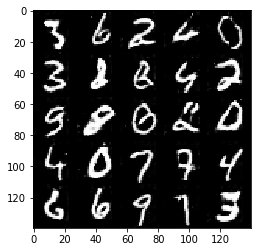

Dataset processed 118720/60000... Epoch 1/2... Discriminator Loss: 0.4260... Generator Loss: 2.1022
Dataset processed 119040/60000... Epoch 1/2... Discriminator Loss: 1.2429... Generator Loss: 0.7273
Dataset processed 119360/60000... Epoch 1/2... Discriminator Loss: 0.4213... Generator Loss: 2.2246
Dataset processed 119680/60000... Epoch 1/2... Discriminator Loss: 0.8172... Generator Loss: 1.2546
Dataset processed 120000/60000... Epoch 1/2... Discriminator Loss: 1.0456... Generator Loss: 0.7632


In [22]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1
alpha = 0.01
smooth = 0.05

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha, smooth)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

epoch
Dataset processed 320/202599... Epoch 0/1... Discriminator Loss: 0.2258... Generator Loss: 8.3499
Dataset processed 640/202599... Epoch 0/1... Discriminator Loss: 0.4035... Generator Loss: 3.1040
Dataset processed 960/202599... Epoch 0/1... Discriminator Loss: 0.2144... Generator Loss: 7.6274
Dataset processed 1280/202599... Epoch 0/1... Discriminator Loss: 0.3042... Generator Loss: 3.4853
Dataset processed 1600/202599... Epoch 0/1... Discriminator Loss: 0.2064... Generator Loss: 6.8670
Dataset processed 1920/202599... Epoch 0/1... Discriminator Loss: 0.2094... Generator Loss: 6.7739
Dataset processed 2240/202599... Epoch 0/1... Discriminator Loss: 0.2394... Generator Loss: 9.8896
Dataset processed 2560/202599... Epoch 0/1... Discriminator Loss: 0.2046... Generator Loss: 6.4345
Dataset processed 2880/202599... Epoch 0/1... Discriminator Loss: 0.3034... Generator Loss: 17.0361
Dataset processed 3200/202599... Epoch 0/1... Discriminator Loss: 0.2119... Generator Loss: 7.1211


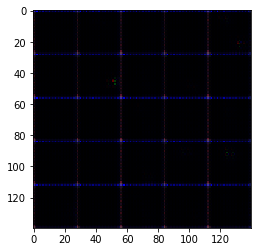

Dataset processed 3520/202599... Epoch 0/1... Discriminator Loss: 0.2033... Generator Loss: 7.5879
Dataset processed 3840/202599... Epoch 0/1... Discriminator Loss: 0.2009... Generator Loss: 8.3229
Dataset processed 4160/202599... Epoch 0/1... Discriminator Loss: 0.2006... Generator Loss: 7.2976
Dataset processed 4480/202599... Epoch 0/1... Discriminator Loss: 0.2022... Generator Loss: 7.4988
Dataset processed 4800/202599... Epoch 0/1... Discriminator Loss: 0.2001... Generator Loss: 8.4997
Dataset processed 5120/202599... Epoch 0/1... Discriminator Loss: 0.2037... Generator Loss: 7.0015
Dataset processed 5440/202599... Epoch 0/1... Discriminator Loss: 0.2151... Generator Loss: 6.2689
Dataset processed 5760/202599... Epoch 0/1... Discriminator Loss: 0.8021... Generator Loss: 15.1580
Dataset processed 6080/202599... Epoch 0/1... Discriminator Loss: 0.3578... Generator Loss: 2.6145
Dataset processed 6400/202599... Epoch 0/1... Discriminator Loss: 2.3699... Generator Loss: 5.0863


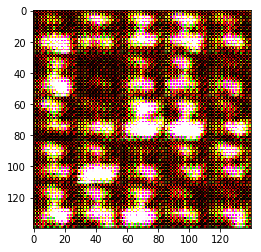

Dataset processed 6720/202599... Epoch 0/1... Discriminator Loss: 0.8760... Generator Loss: 1.7603
Dataset processed 7040/202599... Epoch 0/1... Discriminator Loss: 0.9433... Generator Loss: 1.2761
Dataset processed 7360/202599... Epoch 0/1... Discriminator Loss: 0.8629... Generator Loss: 5.7082
Dataset processed 7680/202599... Epoch 0/1... Discriminator Loss: 0.3834... Generator Loss: 4.9751
Dataset processed 8000/202599... Epoch 0/1... Discriminator Loss: 1.0604... Generator Loss: 1.9954
Dataset processed 8320/202599... Epoch 0/1... Discriminator Loss: 0.3318... Generator Loss: 4.1200
Dataset processed 8640/202599... Epoch 0/1... Discriminator Loss: 0.2659... Generator Loss: 3.3630
Dataset processed 8960/202599... Epoch 0/1... Discriminator Loss: 0.8803... Generator Loss: 1.1152
Dataset processed 9280/202599... Epoch 0/1... Discriminator Loss: 0.2922... Generator Loss: 2.9245
Dataset processed 9600/202599... Epoch 0/1... Discriminator Loss: 0.2425... Generator Loss: 4.1262


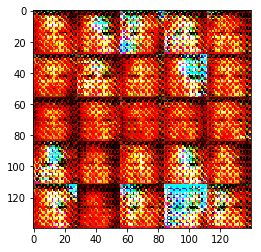

Dataset processed 9920/202599... Epoch 0/1... Discriminator Loss: 0.2692... Generator Loss: 3.8951
Dataset processed 10240/202599... Epoch 0/1... Discriminator Loss: 0.7581... Generator Loss: 1.2290
Dataset processed 10560/202599... Epoch 0/1... Discriminator Loss: 0.4660... Generator Loss: 2.8540
Dataset processed 10880/202599... Epoch 0/1... Discriminator Loss: 0.9797... Generator Loss: 0.9167
Dataset processed 11200/202599... Epoch 0/1... Discriminator Loss: 1.0111... Generator Loss: 3.1069
Dataset processed 11520/202599... Epoch 0/1... Discriminator Loss: 0.9351... Generator Loss: 1.0440
Dataset processed 11840/202599... Epoch 0/1... Discriminator Loss: 1.6676... Generator Loss: 0.5013
Dataset processed 12160/202599... Epoch 0/1... Discriminator Loss: 1.0766... Generator Loss: 0.8335
Dataset processed 12480/202599... Epoch 0/1... Discriminator Loss: 1.9987... Generator Loss: 0.3164
Dataset processed 12800/202599... Epoch 0/1... Discriminator Loss: 2.0836... Generator Loss: 0.2157


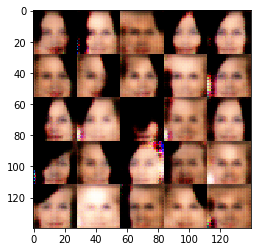

Dataset processed 13120/202599... Epoch 0/1... Discriminator Loss: 2.6339... Generator Loss: 2.8984
Dataset processed 13440/202599... Epoch 0/1... Discriminator Loss: 1.6377... Generator Loss: 0.3324
Dataset processed 13760/202599... Epoch 0/1... Discriminator Loss: 1.5430... Generator Loss: 1.4066
Dataset processed 14080/202599... Epoch 0/1... Discriminator Loss: 1.1864... Generator Loss: 1.5221
Dataset processed 14400/202599... Epoch 0/1... Discriminator Loss: 1.5364... Generator Loss: 1.6428
Dataset processed 14720/202599... Epoch 0/1... Discriminator Loss: 1.2387... Generator Loss: 0.7684
Dataset processed 15040/202599... Epoch 0/1... Discriminator Loss: 1.3055... Generator Loss: 0.6048
Dataset processed 15360/202599... Epoch 0/1... Discriminator Loss: 1.1728... Generator Loss: 0.7392
Dataset processed 15680/202599... Epoch 0/1... Discriminator Loss: 1.7094... Generator Loss: 1.0454
Dataset processed 16000/202599... Epoch 0/1... Discriminator Loss: 0.8912... Generator Loss: 1.0646


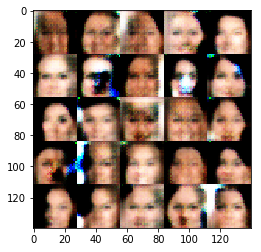

Dataset processed 16320/202599... Epoch 0/1... Discriminator Loss: 0.9898... Generator Loss: 1.1392
Dataset processed 16640/202599... Epoch 0/1... Discriminator Loss: 2.1008... Generator Loss: 0.2083
Dataset processed 16960/202599... Epoch 0/1... Discriminator Loss: 2.3537... Generator Loss: 0.1621
Dataset processed 17280/202599... Epoch 0/1... Discriminator Loss: 0.8383... Generator Loss: 1.2701
Dataset processed 17600/202599... Epoch 0/1... Discriminator Loss: 1.2641... Generator Loss: 0.5995
Dataset processed 17920/202599... Epoch 0/1... Discriminator Loss: 1.0676... Generator Loss: 0.6769
Dataset processed 18240/202599... Epoch 0/1... Discriminator Loss: 1.0611... Generator Loss: 1.6988
Dataset processed 18560/202599... Epoch 0/1... Discriminator Loss: 0.9973... Generator Loss: 1.3506
Dataset processed 18880/202599... Epoch 0/1... Discriminator Loss: 2.3042... Generator Loss: 2.3577
Dataset processed 19200/202599... Epoch 0/1... Discriminator Loss: 4.1736... Generator Loss: 3.6832


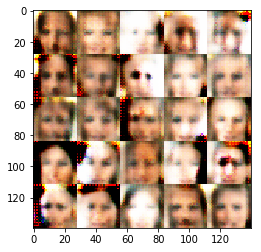

Dataset processed 19520/202599... Epoch 0/1... Discriminator Loss: 1.4314... Generator Loss: 0.5671
Dataset processed 19840/202599... Epoch 0/1... Discriminator Loss: 1.1267... Generator Loss: 1.1389
Dataset processed 20160/202599... Epoch 0/1... Discriminator Loss: 1.1342... Generator Loss: 0.7163
Dataset processed 20480/202599... Epoch 0/1... Discriminator Loss: 1.2199... Generator Loss: 0.9444
Dataset processed 20800/202599... Epoch 0/1... Discriminator Loss: 0.9497... Generator Loss: 0.9892
Dataset processed 21120/202599... Epoch 0/1... Discriminator Loss: 1.0626... Generator Loss: 0.6856
Dataset processed 21440/202599... Epoch 0/1... Discriminator Loss: 0.9146... Generator Loss: 1.2391
Dataset processed 21760/202599... Epoch 0/1... Discriminator Loss: 1.2678... Generator Loss: 0.5664
Dataset processed 22080/202599... Epoch 0/1... Discriminator Loss: 1.2369... Generator Loss: 1.1189
Dataset processed 22400/202599... Epoch 0/1... Discriminator Loss: 1.1854... Generator Loss: 0.8767


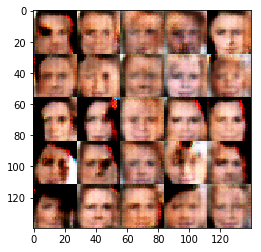

Dataset processed 22720/202599... Epoch 0/1... Discriminator Loss: 1.2563... Generator Loss: 0.4825
Dataset processed 23040/202599... Epoch 0/1... Discriminator Loss: 1.1363... Generator Loss: 0.7036
Dataset processed 23360/202599... Epoch 0/1... Discriminator Loss: 1.2847... Generator Loss: 0.5122
Dataset processed 23680/202599... Epoch 0/1... Discriminator Loss: 1.4014... Generator Loss: 0.4359
Dataset processed 24000/202599... Epoch 0/1... Discriminator Loss: 1.2314... Generator Loss: 0.7313
Dataset processed 24320/202599... Epoch 0/1... Discriminator Loss: 1.3294... Generator Loss: 1.1910
Dataset processed 24640/202599... Epoch 0/1... Discriminator Loss: 1.0517... Generator Loss: 1.3876
Dataset processed 24960/202599... Epoch 0/1... Discriminator Loss: 1.7168... Generator Loss: 0.3362
Dataset processed 25280/202599... Epoch 0/1... Discriminator Loss: 1.2279... Generator Loss: 1.2595
Dataset processed 25600/202599... Epoch 0/1... Discriminator Loss: 1.2756... Generator Loss: 0.7222


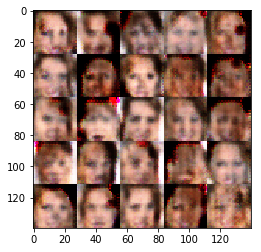

Dataset processed 25920/202599... Epoch 0/1... Discriminator Loss: 0.9091... Generator Loss: 1.0507
Dataset processed 26240/202599... Epoch 0/1... Discriminator Loss: 1.3665... Generator Loss: 0.4862
Dataset processed 26560/202599... Epoch 0/1... Discriminator Loss: 1.4733... Generator Loss: 0.3901
Dataset processed 26880/202599... Epoch 0/1... Discriminator Loss: 1.1339... Generator Loss: 0.5638
Dataset processed 27200/202599... Epoch 0/1... Discriminator Loss: 1.1775... Generator Loss: 0.7736
Dataset processed 27520/202599... Epoch 0/1... Discriminator Loss: 0.9644... Generator Loss: 1.6467
Dataset processed 27840/202599... Epoch 0/1... Discriminator Loss: 0.9966... Generator Loss: 0.8715
Dataset processed 28160/202599... Epoch 0/1... Discriminator Loss: 1.2623... Generator Loss: 1.1870
Dataset processed 28480/202599... Epoch 0/1... Discriminator Loss: 1.6457... Generator Loss: 2.5079
Dataset processed 28800/202599... Epoch 0/1... Discriminator Loss: 1.3685... Generator Loss: 0.5460


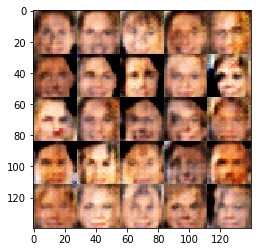

Dataset processed 29120/202599... Epoch 0/1... Discriminator Loss: 1.1679... Generator Loss: 0.8040
Dataset processed 29440/202599... Epoch 0/1... Discriminator Loss: 1.1003... Generator Loss: 1.8458
Dataset processed 29760/202599... Epoch 0/1... Discriminator Loss: 1.1898... Generator Loss: 0.6881
Dataset processed 30080/202599... Epoch 0/1... Discriminator Loss: 0.8759... Generator Loss: 1.0282
Dataset processed 30400/202599... Epoch 0/1... Discriminator Loss: 1.8381... Generator Loss: 0.2504
Dataset processed 30720/202599... Epoch 0/1... Discriminator Loss: 1.1293... Generator Loss: 0.8036
Dataset processed 31040/202599... Epoch 0/1... Discriminator Loss: 1.1834... Generator Loss: 0.5695
Dataset processed 31360/202599... Epoch 0/1... Discriminator Loss: 1.1435... Generator Loss: 0.8931
Dataset processed 31680/202599... Epoch 0/1... Discriminator Loss: 1.3611... Generator Loss: 0.6773
Dataset processed 32000/202599... Epoch 0/1... Discriminator Loss: 1.0690... Generator Loss: 0.7031


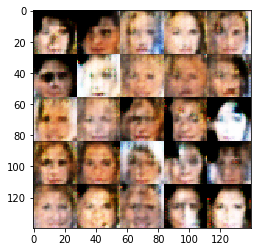

Dataset processed 32320/202599... Epoch 0/1... Discriminator Loss: 0.8389... Generator Loss: 0.9234
Dataset processed 32640/202599... Epoch 0/1... Discriminator Loss: 1.0686... Generator Loss: 2.1156
Dataset processed 32960/202599... Epoch 0/1... Discriminator Loss: 0.7725... Generator Loss: 1.9821
Dataset processed 33280/202599... Epoch 0/1... Discriminator Loss: 1.2034... Generator Loss: 0.6428
Dataset processed 33600/202599... Epoch 0/1... Discriminator Loss: 0.6143... Generator Loss: 1.2842
Dataset processed 33920/202599... Epoch 0/1... Discriminator Loss: 1.1751... Generator Loss: 0.8226
Dataset processed 34240/202599... Epoch 0/1... Discriminator Loss: 1.1155... Generator Loss: 0.6437
Dataset processed 34560/202599... Epoch 0/1... Discriminator Loss: 1.6186... Generator Loss: 1.3199
Dataset processed 34880/202599... Epoch 0/1... Discriminator Loss: 1.0708... Generator Loss: 0.7493
Dataset processed 35200/202599... Epoch 0/1... Discriminator Loss: 1.2694... Generator Loss: 0.5318


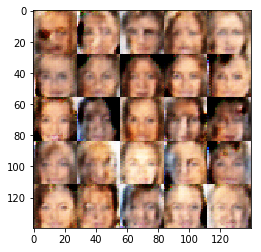

Dataset processed 35520/202599... Epoch 0/1... Discriminator Loss: 1.1451... Generator Loss: 1.4691
Dataset processed 35840/202599... Epoch 0/1... Discriminator Loss: 0.8761... Generator Loss: 1.7901
Dataset processed 36160/202599... Epoch 0/1... Discriminator Loss: 1.4642... Generator Loss: 0.5210
Dataset processed 36480/202599... Epoch 0/1... Discriminator Loss: 0.9265... Generator Loss: 1.4027
Dataset processed 36800/202599... Epoch 0/1... Discriminator Loss: 0.9370... Generator Loss: 0.8728
Dataset processed 37120/202599... Epoch 0/1... Discriminator Loss: 0.9064... Generator Loss: 1.8289
Dataset processed 37440/202599... Epoch 0/1... Discriminator Loss: 1.1710... Generator Loss: 0.5703
Dataset processed 37760/202599... Epoch 0/1... Discriminator Loss: 0.9917... Generator Loss: 0.7181
Dataset processed 38080/202599... Epoch 0/1... Discriminator Loss: 0.7921... Generator Loss: 2.0313
Dataset processed 38400/202599... Epoch 0/1... Discriminator Loss: 1.4361... Generator Loss: 0.6100


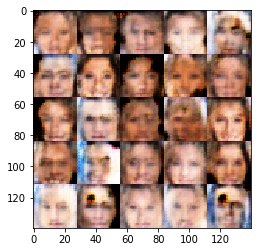

Dataset processed 38720/202599... Epoch 0/1... Discriminator Loss: 2.3442... Generator Loss: 0.1539
Dataset processed 39040/202599... Epoch 0/1... Discriminator Loss: 0.8869... Generator Loss: 1.1066
Dataset processed 39360/202599... Epoch 0/1... Discriminator Loss: 1.4045... Generator Loss: 0.5441
Dataset processed 39680/202599... Epoch 0/1... Discriminator Loss: 2.2164... Generator Loss: 0.1674
Dataset processed 40000/202599... Epoch 0/1... Discriminator Loss: 0.7475... Generator Loss: 1.8186
Dataset processed 40320/202599... Epoch 0/1... Discriminator Loss: 1.3186... Generator Loss: 0.5995
Dataset processed 40640/202599... Epoch 0/1... Discriminator Loss: 1.2157... Generator Loss: 0.8090
Dataset processed 40960/202599... Epoch 0/1... Discriminator Loss: 1.2641... Generator Loss: 0.6121
Dataset processed 41280/202599... Epoch 0/1... Discriminator Loss: 1.0258... Generator Loss: 1.5190
Dataset processed 41600/202599... Epoch 0/1... Discriminator Loss: 1.2893... Generator Loss: 0.5613


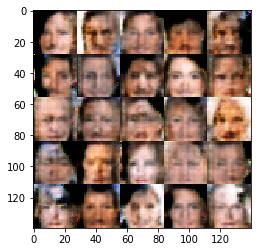

Dataset processed 41920/202599... Epoch 0/1... Discriminator Loss: 1.8414... Generator Loss: 0.2577
Dataset processed 42240/202599... Epoch 0/1... Discriminator Loss: 1.6316... Generator Loss: 0.3898
Dataset processed 42560/202599... Epoch 0/1... Discriminator Loss: 1.0480... Generator Loss: 0.9848
Dataset processed 42880/202599... Epoch 0/1... Discriminator Loss: 1.9394... Generator Loss: 0.2393
Dataset processed 43200/202599... Epoch 0/1... Discriminator Loss: 1.2791... Generator Loss: 0.4875
Dataset processed 43520/202599... Epoch 0/1... Discriminator Loss: 1.0430... Generator Loss: 1.3591
Dataset processed 43840/202599... Epoch 0/1... Discriminator Loss: 1.4885... Generator Loss: 0.7518
Dataset processed 44160/202599... Epoch 0/1... Discriminator Loss: 0.7508... Generator Loss: 1.4363
Dataset processed 44480/202599... Epoch 0/1... Discriminator Loss: 1.0066... Generator Loss: 1.2686
Dataset processed 44800/202599... Epoch 0/1... Discriminator Loss: 1.7534... Generator Loss: 0.2566


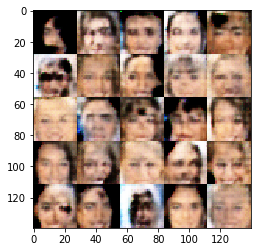

Dataset processed 45120/202599... Epoch 0/1... Discriminator Loss: 1.6983... Generator Loss: 0.2867
Dataset processed 45440/202599... Epoch 0/1... Discriminator Loss: 0.9264... Generator Loss: 1.6934
Dataset processed 45760/202599... Epoch 0/1... Discriminator Loss: 0.7843... Generator Loss: 1.8035
Dataset processed 46080/202599... Epoch 0/1... Discriminator Loss: 1.6934... Generator Loss: 0.4549
Dataset processed 46400/202599... Epoch 0/1... Discriminator Loss: 1.1624... Generator Loss: 1.0419
Dataset processed 46720/202599... Epoch 0/1... Discriminator Loss: 0.7801... Generator Loss: 1.2349
Dataset processed 47040/202599... Epoch 0/1... Discriminator Loss: 0.9664... Generator Loss: 0.9019
Dataset processed 47360/202599... Epoch 0/1... Discriminator Loss: 0.8500... Generator Loss: 0.8317
Dataset processed 47680/202599... Epoch 0/1... Discriminator Loss: 1.1604... Generator Loss: 0.6255
Dataset processed 48000/202599... Epoch 0/1... Discriminator Loss: 1.0249... Generator Loss: 1.4331


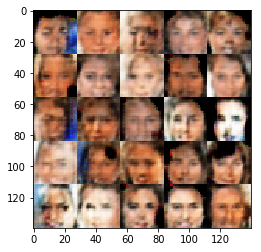

Dataset processed 48320/202599... Epoch 0/1... Discriminator Loss: 1.1074... Generator Loss: 0.7235
Dataset processed 48640/202599... Epoch 0/1... Discriminator Loss: 1.4254... Generator Loss: 0.5020
Dataset processed 48960/202599... Epoch 0/1... Discriminator Loss: 1.0126... Generator Loss: 0.7322
Dataset processed 49280/202599... Epoch 0/1... Discriminator Loss: 0.9503... Generator Loss: 0.9054
Dataset processed 49600/202599... Epoch 0/1... Discriminator Loss: 1.5525... Generator Loss: 0.5005
Dataset processed 49920/202599... Epoch 0/1... Discriminator Loss: 0.5066... Generator Loss: 2.1650
Dataset processed 50240/202599... Epoch 0/1... Discriminator Loss: 1.2689... Generator Loss: 0.7134
Dataset processed 50560/202599... Epoch 0/1... Discriminator Loss: 1.0296... Generator Loss: 1.0246
Dataset processed 50880/202599... Epoch 0/1... Discriminator Loss: 1.2566... Generator Loss: 0.5860
Dataset processed 51200/202599... Epoch 0/1... Discriminator Loss: 0.8809... Generator Loss: 1.3913


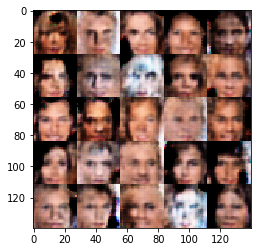

Dataset processed 51520/202599... Epoch 0/1... Discriminator Loss: 1.2949... Generator Loss: 0.6632
Dataset processed 51840/202599... Epoch 0/1... Discriminator Loss: 0.9194... Generator Loss: 1.1709
Dataset processed 52160/202599... Epoch 0/1... Discriminator Loss: 1.0153... Generator Loss: 1.4893
Dataset processed 52480/202599... Epoch 0/1... Discriminator Loss: 1.2518... Generator Loss: 0.6648
Dataset processed 52800/202599... Epoch 0/1... Discriminator Loss: 1.6657... Generator Loss: 0.6166
Dataset processed 53120/202599... Epoch 0/1... Discriminator Loss: 2.2480... Generator Loss: 0.1533
Dataset processed 53440/202599... Epoch 0/1... Discriminator Loss: 1.0916... Generator Loss: 1.1025
Dataset processed 53760/202599... Epoch 0/1... Discriminator Loss: 0.9237... Generator Loss: 1.1889
Dataset processed 54080/202599... Epoch 0/1... Discriminator Loss: 0.9615... Generator Loss: 1.0887
Dataset processed 54400/202599... Epoch 0/1... Discriminator Loss: 1.5911... Generator Loss: 0.4156


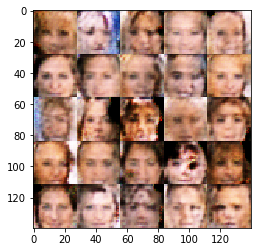

Dataset processed 54720/202599... Epoch 0/1... Discriminator Loss: 0.5564... Generator Loss: 2.2294
Dataset processed 55040/202599... Epoch 0/1... Discriminator Loss: 1.1110... Generator Loss: 1.1613
Dataset processed 55360/202599... Epoch 0/1... Discriminator Loss: 1.0749... Generator Loss: 1.0593
Dataset processed 55680/202599... Epoch 0/1... Discriminator Loss: 0.8901... Generator Loss: 0.8592
Dataset processed 56000/202599... Epoch 0/1... Discriminator Loss: 1.0736... Generator Loss: 0.9673
Dataset processed 56320/202599... Epoch 0/1... Discriminator Loss: 1.8702... Generator Loss: 0.2203
Dataset processed 56640/202599... Epoch 0/1... Discriminator Loss: 0.8643... Generator Loss: 1.1087
Dataset processed 56960/202599... Epoch 0/1... Discriminator Loss: 1.1856... Generator Loss: 0.7921
Dataset processed 57280/202599... Epoch 0/1... Discriminator Loss: 0.7040... Generator Loss: 1.6988
Dataset processed 57600/202599... Epoch 0/1... Discriminator Loss: 1.0598... Generator Loss: 1.1054


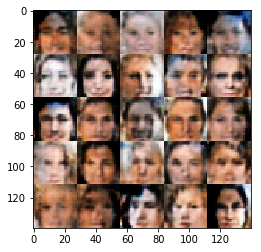

Dataset processed 57920/202599... Epoch 0/1... Discriminator Loss: 1.0498... Generator Loss: 1.1036
Dataset processed 58240/202599... Epoch 0/1... Discriminator Loss: 1.4190... Generator Loss: 0.9410
Dataset processed 58560/202599... Epoch 0/1... Discriminator Loss: 0.9289... Generator Loss: 1.1479
Dataset processed 58880/202599... Epoch 0/1... Discriminator Loss: 1.3582... Generator Loss: 0.5299
Dataset processed 59200/202599... Epoch 0/1... Discriminator Loss: 1.2268... Generator Loss: 1.3477
Dataset processed 59520/202599... Epoch 0/1... Discriminator Loss: 0.5880... Generator Loss: 1.4606
Dataset processed 59840/202599... Epoch 0/1... Discriminator Loss: 0.7249... Generator Loss: 1.1966
Dataset processed 60160/202599... Epoch 0/1... Discriminator Loss: 1.1291... Generator Loss: 0.5449
Dataset processed 60480/202599... Epoch 0/1... Discriminator Loss: 1.5305... Generator Loss: 1.6388
Dataset processed 60800/202599... Epoch 0/1... Discriminator Loss: 0.8761... Generator Loss: 0.9971


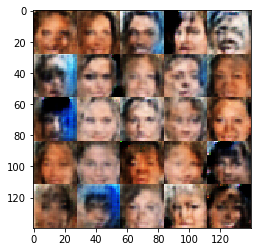

Dataset processed 61120/202599... Epoch 0/1... Discriminator Loss: 1.0793... Generator Loss: 0.6940
Dataset processed 61440/202599... Epoch 0/1... Discriminator Loss: 1.3346... Generator Loss: 0.6353
Dataset processed 61760/202599... Epoch 0/1... Discriminator Loss: 0.7320... Generator Loss: 1.0420
Dataset processed 62080/202599... Epoch 0/1... Discriminator Loss: 2.8916... Generator Loss: 0.0810
Dataset processed 62400/202599... Epoch 0/1... Discriminator Loss: 1.5908... Generator Loss: 1.5161
Dataset processed 62720/202599... Epoch 0/1... Discriminator Loss: 1.1272... Generator Loss: 1.0227
Dataset processed 63040/202599... Epoch 0/1... Discriminator Loss: 1.1975... Generator Loss: 1.5145
Dataset processed 63360/202599... Epoch 0/1... Discriminator Loss: 1.6026... Generator Loss: 0.3562
Dataset processed 63680/202599... Epoch 0/1... Discriminator Loss: 1.1149... Generator Loss: 0.9618
Dataset processed 64000/202599... Epoch 0/1... Discriminator Loss: 1.9489... Generator Loss: 2.6892


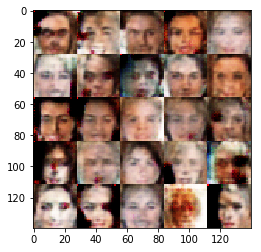

Dataset processed 64320/202599... Epoch 0/1... Discriminator Loss: 1.2294... Generator Loss: 0.8679
Dataset processed 64640/202599... Epoch 0/1... Discriminator Loss: 0.8186... Generator Loss: 1.5433
Dataset processed 64960/202599... Epoch 0/1... Discriminator Loss: 1.0866... Generator Loss: 0.7947
Dataset processed 65280/202599... Epoch 0/1... Discriminator Loss: 1.0222... Generator Loss: 0.7621
Dataset processed 65600/202599... Epoch 0/1... Discriminator Loss: 1.1021... Generator Loss: 1.1750
Dataset processed 65920/202599... Epoch 0/1... Discriminator Loss: 1.1242... Generator Loss: 0.6498
Dataset processed 66240/202599... Epoch 0/1... Discriminator Loss: 2.3918... Generator Loss: 0.1395
Dataset processed 66560/202599... Epoch 0/1... Discriminator Loss: 1.4977... Generator Loss: 0.3418
Dataset processed 66880/202599... Epoch 0/1... Discriminator Loss: 0.9754... Generator Loss: 1.2915
Dataset processed 67200/202599... Epoch 0/1... Discriminator Loss: 2.9627... Generator Loss: 0.0710


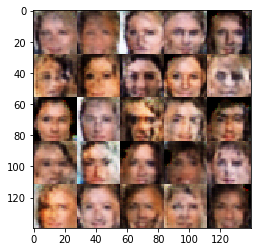

Dataset processed 67520/202599... Epoch 0/1... Discriminator Loss: 1.0962... Generator Loss: 0.8675
Dataset processed 67840/202599... Epoch 0/1... Discriminator Loss: 1.5874... Generator Loss: 1.6433
Dataset processed 68160/202599... Epoch 0/1... Discriminator Loss: 1.1360... Generator Loss: 1.1362
Dataset processed 68480/202599... Epoch 0/1... Discriminator Loss: 1.1891... Generator Loss: 0.5685
Dataset processed 68800/202599... Epoch 0/1... Discriminator Loss: 1.2579... Generator Loss: 0.7942
Dataset processed 69120/202599... Epoch 0/1... Discriminator Loss: 0.9874... Generator Loss: 1.1940
Dataset processed 69440/202599... Epoch 0/1... Discriminator Loss: 1.8448... Generator Loss: 0.2534
Dataset processed 69760/202599... Epoch 0/1... Discriminator Loss: 0.9028... Generator Loss: 1.0579
Dataset processed 70080/202599... Epoch 0/1... Discriminator Loss: 1.6202... Generator Loss: 0.4420
Dataset processed 70400/202599... Epoch 0/1... Discriminator Loss: 1.4918... Generator Loss: 0.3764


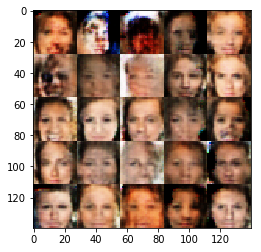

Dataset processed 70720/202599... Epoch 0/1... Discriminator Loss: 0.9256... Generator Loss: 1.7402
Dataset processed 71040/202599... Epoch 0/1... Discriminator Loss: 1.5542... Generator Loss: 0.3489
Dataset processed 71360/202599... Epoch 0/1... Discriminator Loss: 1.0644... Generator Loss: 0.7814
Dataset processed 71680/202599... Epoch 0/1... Discriminator Loss: 1.3656... Generator Loss: 0.5121
Dataset processed 72000/202599... Epoch 0/1... Discriminator Loss: 0.8239... Generator Loss: 0.9122
Dataset processed 72320/202599... Epoch 0/1... Discriminator Loss: 1.3643... Generator Loss: 1.0756
Dataset processed 72640/202599... Epoch 0/1... Discriminator Loss: 0.7814... Generator Loss: 1.1398
Dataset processed 72960/202599... Epoch 0/1... Discriminator Loss: 1.0719... Generator Loss: 0.6881
Dataset processed 73280/202599... Epoch 0/1... Discriminator Loss: 0.9926... Generator Loss: 0.6563
Dataset processed 73600/202599... Epoch 0/1... Discriminator Loss: 1.8528... Generator Loss: 0.2585


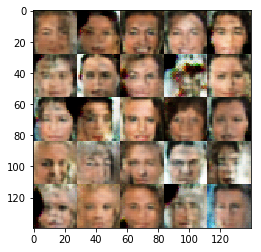

Dataset processed 73920/202599... Epoch 0/1... Discriminator Loss: 0.7032... Generator Loss: 1.4570
Dataset processed 74240/202599... Epoch 0/1... Discriminator Loss: 0.8104... Generator Loss: 0.8508
Dataset processed 74560/202599... Epoch 0/1... Discriminator Loss: 0.7924... Generator Loss: 1.1922
Dataset processed 74880/202599... Epoch 0/1... Discriminator Loss: 0.6650... Generator Loss: 1.2399
Dataset processed 75200/202599... Epoch 0/1... Discriminator Loss: 2.2610... Generator Loss: 2.3583
Dataset processed 75520/202599... Epoch 0/1... Discriminator Loss: 1.9902... Generator Loss: 1.7409
Dataset processed 75840/202599... Epoch 0/1... Discriminator Loss: 1.1542... Generator Loss: 1.0811
Dataset processed 76160/202599... Epoch 0/1... Discriminator Loss: 1.6104... Generator Loss: 1.5652
Dataset processed 76480/202599... Epoch 0/1... Discriminator Loss: 0.6587... Generator Loss: 1.1964
Dataset processed 76800/202599... Epoch 0/1... Discriminator Loss: 1.0042... Generator Loss: 0.8120


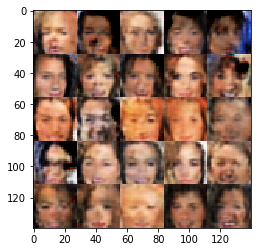

Dataset processed 77120/202599... Epoch 0/1... Discriminator Loss: 1.1431... Generator Loss: 0.7701
Dataset processed 77440/202599... Epoch 0/1... Discriminator Loss: 1.3404... Generator Loss: 0.7987
Dataset processed 77760/202599... Epoch 0/1... Discriminator Loss: 1.3855... Generator Loss: 0.4049
Dataset processed 78080/202599... Epoch 0/1... Discriminator Loss: 1.3649... Generator Loss: 0.4576
Dataset processed 78400/202599... Epoch 0/1... Discriminator Loss: 1.8627... Generator Loss: 0.2256
Dataset processed 78720/202599... Epoch 0/1... Discriminator Loss: 1.2205... Generator Loss: 0.7254
Dataset processed 79040/202599... Epoch 0/1... Discriminator Loss: 1.2731... Generator Loss: 0.8126
Dataset processed 79360/202599... Epoch 0/1... Discriminator Loss: 1.0068... Generator Loss: 1.3799
Dataset processed 79680/202599... Epoch 0/1... Discriminator Loss: 1.1701... Generator Loss: 0.6663
Dataset processed 80000/202599... Epoch 0/1... Discriminator Loss: 1.2061... Generator Loss: 1.3418


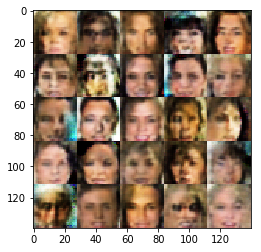

Dataset processed 80320/202599... Epoch 0/1... Discriminator Loss: 1.1973... Generator Loss: 0.5514
Dataset processed 80640/202599... Epoch 0/1... Discriminator Loss: 1.3231... Generator Loss: 0.4620
Dataset processed 80960/202599... Epoch 0/1... Discriminator Loss: 1.1197... Generator Loss: 0.7481
Dataset processed 81280/202599... Epoch 0/1... Discriminator Loss: 1.6178... Generator Loss: 0.3650
Dataset processed 81600/202599... Epoch 0/1... Discriminator Loss: 1.0384... Generator Loss: 0.8964
Dataset processed 81920/202599... Epoch 0/1... Discriminator Loss: 2.2915... Generator Loss: 0.1450
Dataset processed 82240/202599... Epoch 0/1... Discriminator Loss: 1.3543... Generator Loss: 0.6170
Dataset processed 82560/202599... Epoch 0/1... Discriminator Loss: 1.0482... Generator Loss: 0.7684
Dataset processed 82880/202599... Epoch 0/1... Discriminator Loss: 1.5501... Generator Loss: 0.9776
Dataset processed 83200/202599... Epoch 0/1... Discriminator Loss: 1.5462... Generator Loss: 0.3645


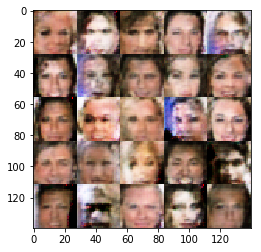

Dataset processed 83520/202599... Epoch 0/1... Discriminator Loss: 1.4275... Generator Loss: 1.9459
Dataset processed 83840/202599... Epoch 0/1... Discriminator Loss: 1.7731... Generator Loss: 1.7917
Dataset processed 84160/202599... Epoch 0/1... Discriminator Loss: 1.2190... Generator Loss: 0.5645
Dataset processed 84480/202599... Epoch 0/1... Discriminator Loss: 1.2038... Generator Loss: 0.8581
Dataset processed 84800/202599... Epoch 0/1... Discriminator Loss: 1.1630... Generator Loss: 0.7839
Dataset processed 85120/202599... Epoch 0/1... Discriminator Loss: 0.8986... Generator Loss: 0.8553
Dataset processed 85440/202599... Epoch 0/1... Discriminator Loss: 0.4723... Generator Loss: 1.5830
Dataset processed 85760/202599... Epoch 0/1... Discriminator Loss: 0.4348... Generator Loss: 1.7453
Dataset processed 86080/202599... Epoch 0/1... Discriminator Loss: 0.7214... Generator Loss: 1.0927
Dataset processed 86400/202599... Epoch 0/1... Discriminator Loss: 1.5248... Generator Loss: 1.6892


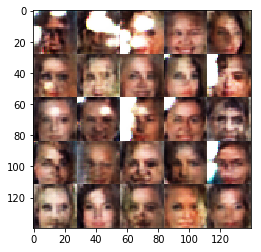

Dataset processed 86720/202599... Epoch 0/1... Discriminator Loss: 1.1225... Generator Loss: 0.9261
Dataset processed 87040/202599... Epoch 0/1... Discriminator Loss: 1.0537... Generator Loss: 0.7592
Dataset processed 87360/202599... Epoch 0/1... Discriminator Loss: 0.8340... Generator Loss: 1.0086
Dataset processed 87680/202599... Epoch 0/1... Discriminator Loss: 0.7704... Generator Loss: 0.9307
Dataset processed 88000/202599... Epoch 0/1... Discriminator Loss: 0.8694... Generator Loss: 0.8005
Dataset processed 88320/202599... Epoch 0/1... Discriminator Loss: 2.0277... Generator Loss: 0.1965
Dataset processed 88640/202599... Epoch 0/1... Discriminator Loss: 0.6734... Generator Loss: 1.3958
Dataset processed 88960/202599... Epoch 0/1... Discriminator Loss: 0.5575... Generator Loss: 1.3033
Dataset processed 89280/202599... Epoch 0/1... Discriminator Loss: 0.6073... Generator Loss: 1.3349
Dataset processed 89600/202599... Epoch 0/1... Discriminator Loss: 0.5395... Generator Loss: 1.5521


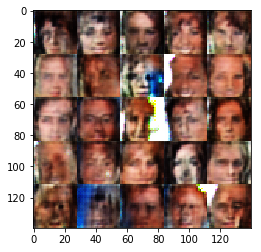

Dataset processed 89920/202599... Epoch 0/1... Discriminator Loss: 0.8739... Generator Loss: 0.8810
Dataset processed 90240/202599... Epoch 0/1... Discriminator Loss: 0.3754... Generator Loss: 2.8507
Dataset processed 90560/202599... Epoch 0/1... Discriminator Loss: 0.7927... Generator Loss: 0.9629
Dataset processed 90880/202599... Epoch 0/1... Discriminator Loss: 0.6030... Generator Loss: 1.7296
Dataset processed 91200/202599... Epoch 0/1... Discriminator Loss: 2.8417... Generator Loss: 0.0847
Dataset processed 91520/202599... Epoch 0/1... Discriminator Loss: 1.0066... Generator Loss: 1.2798
Dataset processed 91840/202599... Epoch 0/1... Discriminator Loss: 0.9332... Generator Loss: 0.7731
Dataset processed 92160/202599... Epoch 0/1... Discriminator Loss: 0.5477... Generator Loss: 1.5029
Dataset processed 92480/202599... Epoch 0/1... Discriminator Loss: 0.4262... Generator Loss: 1.7903
Dataset processed 92800/202599... Epoch 0/1... Discriminator Loss: 0.9756... Generator Loss: 1.1872


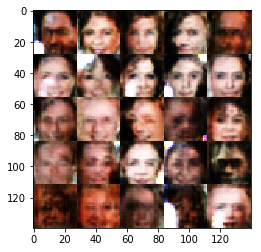

Dataset processed 93120/202599... Epoch 0/1... Discriminator Loss: 0.6938... Generator Loss: 1.0818
Dataset processed 93440/202599... Epoch 0/1... Discriminator Loss: 0.8887... Generator Loss: 0.8534
Dataset processed 93760/202599... Epoch 0/1... Discriminator Loss: 0.6882... Generator Loss: 1.1526
Dataset processed 94080/202599... Epoch 0/1... Discriminator Loss: 0.8443... Generator Loss: 0.8065
Dataset processed 94400/202599... Epoch 0/1... Discriminator Loss: 0.5313... Generator Loss: 1.3651
Dataset processed 94720/202599... Epoch 0/1... Discriminator Loss: 0.4589... Generator Loss: 1.8287
Dataset processed 95040/202599... Epoch 0/1... Discriminator Loss: 0.3540... Generator Loss: 2.1044
Dataset processed 95360/202599... Epoch 0/1... Discriminator Loss: 1.3897... Generator Loss: 1.1338
Dataset processed 95680/202599... Epoch 0/1... Discriminator Loss: 0.9118... Generator Loss: 2.5423
Dataset processed 96000/202599... Epoch 0/1... Discriminator Loss: 0.4057... Generator Loss: 1.9384


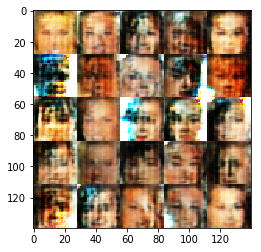

Dataset processed 96320/202599... Epoch 0/1... Discriminator Loss: 0.8638... Generator Loss: 0.8517
Dataset processed 96640/202599... Epoch 0/1... Discriminator Loss: 1.6827... Generator Loss: 0.3086
Dataset processed 96960/202599... Epoch 0/1... Discriminator Loss: 0.4893... Generator Loss: 2.4399
Dataset processed 97280/202599... Epoch 0/1... Discriminator Loss: 1.0970... Generator Loss: 0.5866
Dataset processed 97600/202599... Epoch 0/1... Discriminator Loss: 0.8912... Generator Loss: 0.8405
Dataset processed 97920/202599... Epoch 0/1... Discriminator Loss: 2.0909... Generator Loss: 0.2020
Dataset processed 98240/202599... Epoch 0/1... Discriminator Loss: 0.5016... Generator Loss: 1.6860
Dataset processed 98560/202599... Epoch 0/1... Discriminator Loss: 0.5890... Generator Loss: 1.2674
Dataset processed 98880/202599... Epoch 0/1... Discriminator Loss: 0.6967... Generator Loss: 1.1892
Dataset processed 99200/202599... Epoch 0/1... Discriminator Loss: 2.3430... Generator Loss: 0.1462


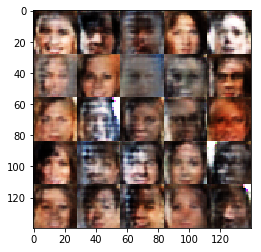

Dataset processed 99520/202599... Epoch 0/1... Discriminator Loss: 1.3001... Generator Loss: 0.8927
Dataset processed 99840/202599... Epoch 0/1... Discriminator Loss: 2.5628... Generator Loss: 0.1313
Dataset processed 100160/202599... Epoch 0/1... Discriminator Loss: 2.5827... Generator Loss: 0.1337
Dataset processed 100480/202599... Epoch 0/1... Discriminator Loss: 1.4926... Generator Loss: 0.5075
Dataset processed 100800/202599... Epoch 0/1... Discriminator Loss: 1.1981... Generator Loss: 0.7905
Dataset processed 101120/202599... Epoch 0/1... Discriminator Loss: 1.4768... Generator Loss: 0.7939
Dataset processed 101440/202599... Epoch 0/1... Discriminator Loss: 1.1554... Generator Loss: 0.8380
Dataset processed 101760/202599... Epoch 0/1... Discriminator Loss: 1.5395... Generator Loss: 0.5288
Dataset processed 102080/202599... Epoch 0/1... Discriminator Loss: 1.5186... Generator Loss: 0.4738
Dataset processed 102400/202599... Epoch 0/1... Discriminator Loss: 1.5330... Generator Loss:

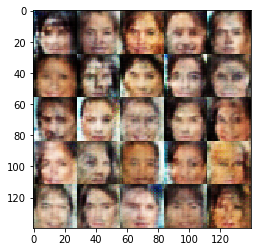

Dataset processed 102720/202599... Epoch 0/1... Discriminator Loss: 1.3568... Generator Loss: 0.5844
Dataset processed 103040/202599... Epoch 0/1... Discriminator Loss: 0.9825... Generator Loss: 1.1374
Dataset processed 103360/202599... Epoch 0/1... Discriminator Loss: 1.3463... Generator Loss: 0.8554
Dataset processed 103680/202599... Epoch 0/1... Discriminator Loss: 1.5176... Generator Loss: 0.5907
Dataset processed 104000/202599... Epoch 0/1... Discriminator Loss: 1.3345... Generator Loss: 0.7580
Dataset processed 104320/202599... Epoch 0/1... Discriminator Loss: 1.0805... Generator Loss: 0.7186
Dataset processed 104640/202599... Epoch 0/1... Discriminator Loss: 1.6440... Generator Loss: 0.4229
Dataset processed 104960/202599... Epoch 0/1... Discriminator Loss: 1.2969... Generator Loss: 0.6811
Dataset processed 105280/202599... Epoch 0/1... Discriminator Loss: 1.6303... Generator Loss: 0.5830
Dataset processed 105600/202599... Epoch 0/1... Discriminator Loss: 1.2397... Generator Los

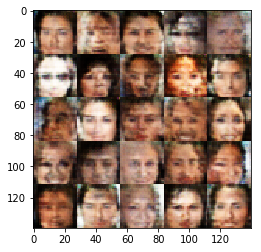

Dataset processed 105920/202599... Epoch 0/1... Discriminator Loss: 1.3942... Generator Loss: 0.5893
Dataset processed 106240/202599... Epoch 0/1... Discriminator Loss: 1.2764... Generator Loss: 0.6264
Dataset processed 106560/202599... Epoch 0/1... Discriminator Loss: 1.3889... Generator Loss: 0.7789
Dataset processed 106880/202599... Epoch 0/1... Discriminator Loss: 1.3780... Generator Loss: 0.6645
Dataset processed 107200/202599... Epoch 0/1... Discriminator Loss: 1.1938... Generator Loss: 1.5052
Dataset processed 107520/202599... Epoch 0/1... Discriminator Loss: 1.1078... Generator Loss: 0.8072
Dataset processed 107840/202599... Epoch 0/1... Discriminator Loss: 1.3778... Generator Loss: 0.8101
Dataset processed 108160/202599... Epoch 0/1... Discriminator Loss: 1.3505... Generator Loss: 0.6893
Dataset processed 108480/202599... Epoch 0/1... Discriminator Loss: 1.3242... Generator Loss: 0.8268
Dataset processed 108800/202599... Epoch 0/1... Discriminator Loss: 1.2737... Generator Los

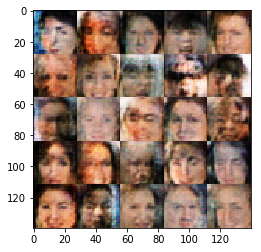

Dataset processed 109120/202599... Epoch 0/1... Discriminator Loss: 1.6127... Generator Loss: 0.4540
Dataset processed 109440/202599... Epoch 0/1... Discriminator Loss: 1.1689... Generator Loss: 0.8176
Dataset processed 109760/202599... Epoch 0/1... Discriminator Loss: 1.5449... Generator Loss: 0.4576
Dataset processed 110080/202599... Epoch 0/1... Discriminator Loss: 1.2177... Generator Loss: 0.7076
Dataset processed 110400/202599... Epoch 0/1... Discriminator Loss: 1.2469... Generator Loss: 0.6153
Dataset processed 110720/202599... Epoch 0/1... Discriminator Loss: 1.4134... Generator Loss: 0.9774
Dataset processed 111040/202599... Epoch 0/1... Discriminator Loss: 1.2364... Generator Loss: 0.5748
Dataset processed 111360/202599... Epoch 0/1... Discriminator Loss: 1.2602... Generator Loss: 0.6941
Dataset processed 111680/202599... Epoch 0/1... Discriminator Loss: 1.2722... Generator Loss: 0.6527
Dataset processed 112000/202599... Epoch 0/1... Discriminator Loss: 1.2935... Generator Los

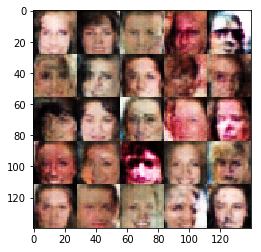

Dataset processed 112320/202599... Epoch 0/1... Discriminator Loss: 1.3620... Generator Loss: 0.7167
Dataset processed 112640/202599... Epoch 0/1... Discriminator Loss: 1.3407... Generator Loss: 0.7065
Dataset processed 112960/202599... Epoch 0/1... Discriminator Loss: 1.1315... Generator Loss: 0.6558
Dataset processed 113280/202599... Epoch 0/1... Discriminator Loss: 1.6194... Generator Loss: 0.3949
Dataset processed 113600/202599... Epoch 0/1... Discriminator Loss: 1.2832... Generator Loss: 0.5468
Dataset processed 113920/202599... Epoch 0/1... Discriminator Loss: 1.2997... Generator Loss: 0.5769
Dataset processed 114240/202599... Epoch 0/1... Discriminator Loss: 0.9965... Generator Loss: 0.7053
Dataset processed 114560/202599... Epoch 0/1... Discriminator Loss: 1.4620... Generator Loss: 0.5001
Dataset processed 114880/202599... Epoch 0/1... Discriminator Loss: 1.3777... Generator Loss: 0.5957
Dataset processed 115200/202599... Epoch 0/1... Discriminator Loss: 1.2581... Generator Los

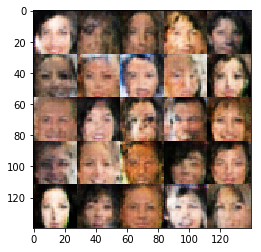

Dataset processed 115520/202599... Epoch 0/1... Discriminator Loss: 1.4574... Generator Loss: 0.6070
Dataset processed 115840/202599... Epoch 0/1... Discriminator Loss: 1.3879... Generator Loss: 0.5713
Dataset processed 116160/202599... Epoch 0/1... Discriminator Loss: 1.0799... Generator Loss: 0.6122
Dataset processed 116480/202599... Epoch 0/1... Discriminator Loss: 1.3774... Generator Loss: 0.5698
Dataset processed 116800/202599... Epoch 0/1... Discriminator Loss: 1.4083... Generator Loss: 0.6500
Dataset processed 117120/202599... Epoch 0/1... Discriminator Loss: 1.5393... Generator Loss: 0.6004
Dataset processed 117440/202599... Epoch 0/1... Discriminator Loss: 1.4022... Generator Loss: 0.6328
Dataset processed 117760/202599... Epoch 0/1... Discriminator Loss: 1.3248... Generator Loss: 0.6708
Dataset processed 118080/202599... Epoch 0/1... Discriminator Loss: 1.4551... Generator Loss: 0.6389
Dataset processed 118400/202599... Epoch 0/1... Discriminator Loss: 1.4636... Generator Los

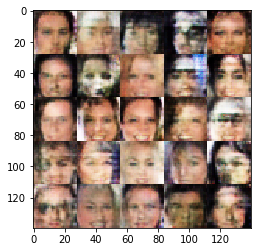

Dataset processed 118720/202599... Epoch 0/1... Discriminator Loss: 1.1840... Generator Loss: 0.8042
Dataset processed 119040/202599... Epoch 0/1... Discriminator Loss: 1.1681... Generator Loss: 0.5705
Dataset processed 119360/202599... Epoch 0/1... Discriminator Loss: 1.0744... Generator Loss: 0.7301
Dataset processed 119680/202599... Epoch 0/1... Discriminator Loss: 1.1310... Generator Loss: 0.9509
Dataset processed 120000/202599... Epoch 0/1... Discriminator Loss: 1.3811... Generator Loss: 0.6179
Dataset processed 120320/202599... Epoch 0/1... Discriminator Loss: 1.3925... Generator Loss: 0.6330
Dataset processed 120640/202599... Epoch 0/1... Discriminator Loss: 1.1594... Generator Loss: 1.0851
Dataset processed 120960/202599... Epoch 0/1... Discriminator Loss: 1.1937... Generator Loss: 0.8228
Dataset processed 121280/202599... Epoch 0/1... Discriminator Loss: 1.3120... Generator Loss: 0.8132
Dataset processed 121600/202599... Epoch 0/1... Discriminator Loss: 1.4401... Generator Los

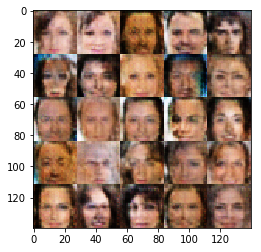

Dataset processed 121920/202599... Epoch 0/1... Discriminator Loss: 1.5328... Generator Loss: 0.4288
Dataset processed 122240/202599... Epoch 0/1... Discriminator Loss: 1.1685... Generator Loss: 0.6398
Dataset processed 122560/202599... Epoch 0/1... Discriminator Loss: 1.3029... Generator Loss: 0.7257
Dataset processed 122880/202599... Epoch 0/1... Discriminator Loss: 1.3550... Generator Loss: 0.7290
Dataset processed 123200/202599... Epoch 0/1... Discriminator Loss: 1.3380... Generator Loss: 0.5869
Dataset processed 123520/202599... Epoch 0/1... Discriminator Loss: 1.5988... Generator Loss: 0.3403
Dataset processed 123840/202599... Epoch 0/1... Discriminator Loss: 1.2483... Generator Loss: 0.6266
Dataset processed 124160/202599... Epoch 0/1... Discriminator Loss: 1.0954... Generator Loss: 0.6311
Dataset processed 124480/202599... Epoch 0/1... Discriminator Loss: 1.4651... Generator Loss: 0.4722
Dataset processed 124800/202599... Epoch 0/1... Discriminator Loss: 1.3379... Generator Los

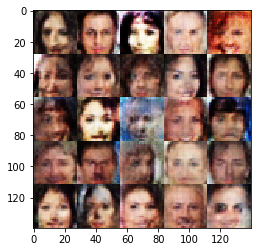

Dataset processed 125120/202599... Epoch 0/1... Discriminator Loss: 1.3620... Generator Loss: 0.5650
Dataset processed 125440/202599... Epoch 0/1... Discriminator Loss: 1.3581... Generator Loss: 0.6288
Dataset processed 125760/202599... Epoch 0/1... Discriminator Loss: 1.1912... Generator Loss: 0.7025
Dataset processed 126080/202599... Epoch 0/1... Discriminator Loss: 1.6189... Generator Loss: 0.3415
Dataset processed 126400/202599... Epoch 0/1... Discriminator Loss: 1.3285... Generator Loss: 0.8872
Dataset processed 126720/202599... Epoch 0/1... Discriminator Loss: 1.4373... Generator Loss: 0.4766
Dataset processed 127040/202599... Epoch 0/1... Discriminator Loss: 1.3965... Generator Loss: 0.7301
Dataset processed 127360/202599... Epoch 0/1... Discriminator Loss: 1.1327... Generator Loss: 0.6153
Dataset processed 127680/202599... Epoch 0/1... Discriminator Loss: 1.3682... Generator Loss: 0.4593
Dataset processed 128000/202599... Epoch 0/1... Discriminator Loss: 1.6468... Generator Los

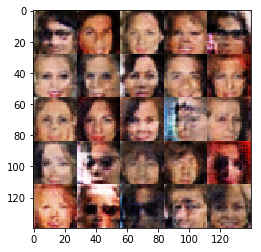

Dataset processed 128320/202599... Epoch 0/1... Discriminator Loss: 1.3272... Generator Loss: 0.7506
Dataset processed 128640/202599... Epoch 0/1... Discriminator Loss: 1.5004... Generator Loss: 0.4632
Dataset processed 128960/202599... Epoch 0/1... Discriminator Loss: 1.6263... Generator Loss: 0.4773
Dataset processed 129280/202599... Epoch 0/1... Discriminator Loss: 1.2049... Generator Loss: 0.6380
Dataset processed 129600/202599... Epoch 0/1... Discriminator Loss: 1.1953... Generator Loss: 0.8001
Dataset processed 129920/202599... Epoch 0/1... Discriminator Loss: 1.4066... Generator Loss: 0.7645
Dataset processed 130240/202599... Epoch 0/1... Discriminator Loss: 1.2864... Generator Loss: 0.6332
Dataset processed 130560/202599... Epoch 0/1... Discriminator Loss: 1.0169... Generator Loss: 0.7313
Dataset processed 130880/202599... Epoch 0/1... Discriminator Loss: 1.4064... Generator Loss: 0.6780
Dataset processed 131200/202599... Epoch 0/1... Discriminator Loss: 1.2724... Generator Los

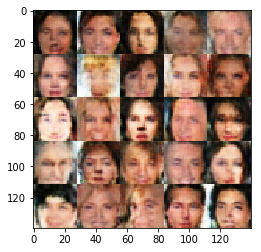

Dataset processed 131520/202599... Epoch 0/1... Discriminator Loss: 1.4204... Generator Loss: 0.7381
Dataset processed 131840/202599... Epoch 0/1... Discriminator Loss: 1.3665... Generator Loss: 0.6510
Dataset processed 132160/202599... Epoch 0/1... Discriminator Loss: 1.2593... Generator Loss: 0.7571
Dataset processed 132480/202599... Epoch 0/1... Discriminator Loss: 1.4518... Generator Loss: 0.5542
Dataset processed 132800/202599... Epoch 0/1... Discriminator Loss: 1.2583... Generator Loss: 0.5486
Dataset processed 133120/202599... Epoch 0/1... Discriminator Loss: 1.3616... Generator Loss: 0.5909
Dataset processed 133440/202599... Epoch 0/1... Discriminator Loss: 1.3816... Generator Loss: 0.5722
Dataset processed 133760/202599... Epoch 0/1... Discriminator Loss: 1.3496... Generator Loss: 0.5923
Dataset processed 134080/202599... Epoch 0/1... Discriminator Loss: 1.3027... Generator Loss: 0.5548
Dataset processed 134400/202599... Epoch 0/1... Discriminator Loss: 1.3606... Generator Los

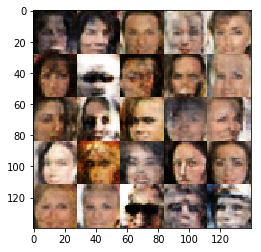

Dataset processed 134720/202599... Epoch 0/1... Discriminator Loss: 1.3195... Generator Loss: 0.6526
Dataset processed 135040/202599... Epoch 0/1... Discriminator Loss: 1.3717... Generator Loss: 0.6810
Dataset processed 135360/202599... Epoch 0/1... Discriminator Loss: 1.4323... Generator Loss: 0.5296
Dataset processed 135680/202599... Epoch 0/1... Discriminator Loss: 1.2485... Generator Loss: 0.7307
Dataset processed 136000/202599... Epoch 0/1... Discriminator Loss: 1.5267... Generator Loss: 0.7557
Dataset processed 136320/202599... Epoch 0/1... Discriminator Loss: 1.3466... Generator Loss: 0.5919
Dataset processed 136640/202599... Epoch 0/1... Discriminator Loss: 1.3331... Generator Loss: 0.7271
Dataset processed 136960/202599... Epoch 0/1... Discriminator Loss: 1.2969... Generator Loss: 0.8661
Dataset processed 137280/202599... Epoch 0/1... Discriminator Loss: 1.3244... Generator Loss: 0.7343
Dataset processed 137600/202599... Epoch 0/1... Discriminator Loss: 1.2898... Generator Los

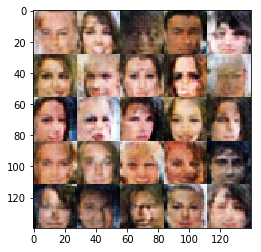

Dataset processed 137920/202599... Epoch 0/1... Discriminator Loss: 1.1959... Generator Loss: 0.8159
Dataset processed 138240/202599... Epoch 0/1... Discriminator Loss: 1.3750... Generator Loss: 0.6572
Dataset processed 138560/202599... Epoch 0/1... Discriminator Loss: 1.2102... Generator Loss: 0.7254
Dataset processed 138880/202599... Epoch 0/1... Discriminator Loss: 1.1520... Generator Loss: 0.7714
Dataset processed 139200/202599... Epoch 0/1... Discriminator Loss: 1.3456... Generator Loss: 0.7344
Dataset processed 139520/202599... Epoch 0/1... Discriminator Loss: 1.3326... Generator Loss: 0.7759
Dataset processed 139840/202599... Epoch 0/1... Discriminator Loss: 1.4901... Generator Loss: 0.3788
Dataset processed 140160/202599... Epoch 0/1... Discriminator Loss: 1.5104... Generator Loss: 0.7336
Dataset processed 140480/202599... Epoch 0/1... Discriminator Loss: 1.3381... Generator Loss: 0.5829
Dataset processed 140800/202599... Epoch 0/1... Discriminator Loss: 1.2969... Generator Los

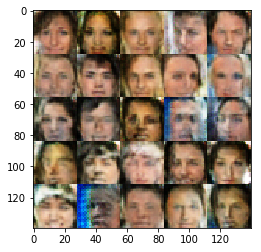

Dataset processed 141120/202599... Epoch 0/1... Discriminator Loss: 1.2469... Generator Loss: 0.6846
Dataset processed 141440/202599... Epoch 0/1... Discriminator Loss: 1.3970... Generator Loss: 0.4727
Dataset processed 141760/202599... Epoch 0/1... Discriminator Loss: 0.9106... Generator Loss: 0.9481
Dataset processed 142080/202599... Epoch 0/1... Discriminator Loss: 1.3087... Generator Loss: 0.7657
Dataset processed 142400/202599... Epoch 0/1... Discriminator Loss: 1.2577... Generator Loss: 0.6298
Dataset processed 142720/202599... Epoch 0/1... Discriminator Loss: 1.2641... Generator Loss: 0.8912
Dataset processed 143040/202599... Epoch 0/1... Discriminator Loss: 1.2003... Generator Loss: 0.7838
Dataset processed 143360/202599... Epoch 0/1... Discriminator Loss: 1.1486... Generator Loss: 0.6617
Dataset processed 143680/202599... Epoch 0/1... Discriminator Loss: 1.1014... Generator Loss: 0.8482
Dataset processed 144000/202599... Epoch 0/1... Discriminator Loss: 1.1404... Generator Los

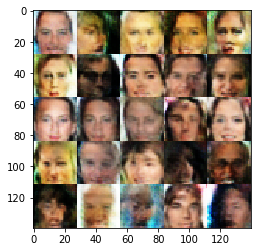

Dataset processed 144320/202599... Epoch 0/1... Discriminator Loss: 1.3228... Generator Loss: 0.4922
Dataset processed 144640/202599... Epoch 0/1... Discriminator Loss: 1.5967... Generator Loss: 0.4597
Dataset processed 144960/202599... Epoch 0/1... Discriminator Loss: 1.0406... Generator Loss: 1.1686
Dataset processed 145280/202599... Epoch 0/1... Discriminator Loss: 1.1113... Generator Loss: 0.7059
Dataset processed 145600/202599... Epoch 0/1... Discriminator Loss: 1.4873... Generator Loss: 0.6538
Dataset processed 145920/202599... Epoch 0/1... Discriminator Loss: 1.1654... Generator Loss: 0.6536
Dataset processed 146240/202599... Epoch 0/1... Discriminator Loss: 1.1887... Generator Loss: 0.8771
Dataset processed 146560/202599... Epoch 0/1... Discriminator Loss: 0.7664... Generator Loss: 1.3448
Dataset processed 146880/202599... Epoch 0/1... Discriminator Loss: 1.0146... Generator Loss: 0.7305
Dataset processed 147200/202599... Epoch 0/1... Discriminator Loss: 1.4396... Generator Los

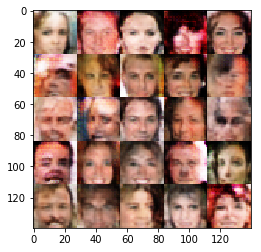

Dataset processed 147520/202599... Epoch 0/1... Discriminator Loss: 1.3979... Generator Loss: 0.5250
Dataset processed 147840/202599... Epoch 0/1... Discriminator Loss: 1.0325... Generator Loss: 1.2036
Dataset processed 148160/202599... Epoch 0/1... Discriminator Loss: 1.1271... Generator Loss: 0.7628
Dataset processed 148480/202599... Epoch 0/1... Discriminator Loss: 1.7565... Generator Loss: 0.2945
Dataset processed 148800/202599... Epoch 0/1... Discriminator Loss: 1.2869... Generator Loss: 0.6392
Dataset processed 149120/202599... Epoch 0/1... Discriminator Loss: 1.1225... Generator Loss: 0.6639
Dataset processed 149440/202599... Epoch 0/1... Discriminator Loss: 1.2519... Generator Loss: 1.3349
Dataset processed 149760/202599... Epoch 0/1... Discriminator Loss: 1.0849... Generator Loss: 1.1708
Dataset processed 150080/202599... Epoch 0/1... Discriminator Loss: 1.2174... Generator Loss: 0.9142
Dataset processed 150400/202599... Epoch 0/1... Discriminator Loss: 1.3806... Generator Los

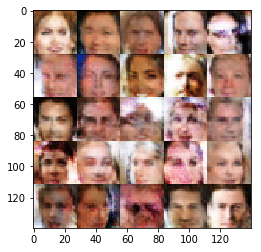

Dataset processed 150720/202599... Epoch 0/1... Discriminator Loss: 1.6822... Generator Loss: 0.3634
Dataset processed 151040/202599... Epoch 0/1... Discriminator Loss: 1.0503... Generator Loss: 0.7187
Dataset processed 151360/202599... Epoch 0/1... Discriminator Loss: 1.9028... Generator Loss: 0.3055
Dataset processed 151680/202599... Epoch 0/1... Discriminator Loss: 1.4376... Generator Loss: 0.8859
Dataset processed 152000/202599... Epoch 0/1... Discriminator Loss: 1.0707... Generator Loss: 1.0765
Dataset processed 152320/202599... Epoch 0/1... Discriminator Loss: 1.2627... Generator Loss: 0.6211
Dataset processed 152640/202599... Epoch 0/1... Discriminator Loss: 1.0045... Generator Loss: 0.7322
Dataset processed 152960/202599... Epoch 0/1... Discriminator Loss: 1.6386... Generator Loss: 0.3719
Dataset processed 153280/202599... Epoch 0/1... Discriminator Loss: 1.1746... Generator Loss: 0.8798
Dataset processed 153600/202599... Epoch 0/1... Discriminator Loss: 1.3387... Generator Los

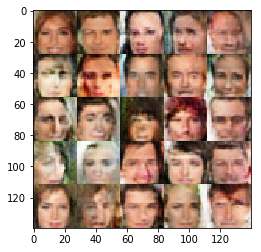

Dataset processed 153920/202599... Epoch 0/1... Discriminator Loss: 1.6272... Generator Loss: 0.3705
Dataset processed 154240/202599... Epoch 0/1... Discriminator Loss: 1.3446... Generator Loss: 0.7060
Dataset processed 154560/202599... Epoch 0/1... Discriminator Loss: 1.4263... Generator Loss: 0.5067
Dataset processed 154880/202599... Epoch 0/1... Discriminator Loss: 1.3671... Generator Loss: 0.5223
Dataset processed 155200/202599... Epoch 0/1... Discriminator Loss: 1.5078... Generator Loss: 0.5581
Dataset processed 155520/202599... Epoch 0/1... Discriminator Loss: 1.4008... Generator Loss: 0.5328
Dataset processed 155840/202599... Epoch 0/1... Discriminator Loss: 1.2567... Generator Loss: 0.8875
Dataset processed 156160/202599... Epoch 0/1... Discriminator Loss: 1.4063... Generator Loss: 0.9877
Dataset processed 156480/202599... Epoch 0/1... Discriminator Loss: 1.3802... Generator Loss: 0.5154
Dataset processed 156800/202599... Epoch 0/1... Discriminator Loss: 1.3437... Generator Los

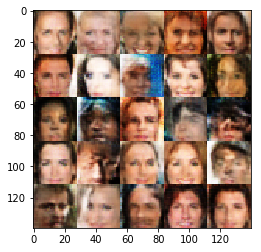

Dataset processed 157120/202599... Epoch 0/1... Discriminator Loss: 1.5365... Generator Loss: 0.8008
Dataset processed 157440/202599... Epoch 0/1... Discriminator Loss: 1.3653... Generator Loss: 0.6582
Dataset processed 157760/202599... Epoch 0/1... Discriminator Loss: 1.5459... Generator Loss: 0.3651
Dataset processed 158080/202599... Epoch 0/1... Discriminator Loss: 1.5170... Generator Loss: 0.5400
Dataset processed 158400/202599... Epoch 0/1... Discriminator Loss: 1.2969... Generator Loss: 0.8159
Dataset processed 158720/202599... Epoch 0/1... Discriminator Loss: 1.3384... Generator Loss: 0.5941
Dataset processed 159040/202599... Epoch 0/1... Discriminator Loss: 1.3960... Generator Loss: 0.5838
Dataset processed 159360/202599... Epoch 0/1... Discriminator Loss: 1.2725... Generator Loss: 0.7468
Dataset processed 159680/202599... Epoch 0/1... Discriminator Loss: 1.3157... Generator Loss: 0.7713
Dataset processed 160000/202599... Epoch 0/1... Discriminator Loss: 1.3511... Generator Los

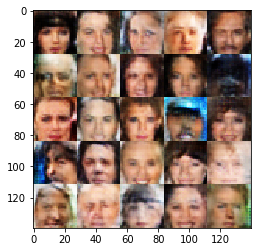

Dataset processed 160320/202599... Epoch 0/1... Discriminator Loss: 1.2834... Generator Loss: 0.6484
Dataset processed 160640/202599... Epoch 0/1... Discriminator Loss: 1.2759... Generator Loss: 0.5324
Dataset processed 160960/202599... Epoch 0/1... Discriminator Loss: 1.2998... Generator Loss: 0.8091
Dataset processed 161280/202599... Epoch 0/1... Discriminator Loss: 1.3962... Generator Loss: 0.4693
Dataset processed 161600/202599... Epoch 0/1... Discriminator Loss: 1.3229... Generator Loss: 0.7681
Dataset processed 161920/202599... Epoch 0/1... Discriminator Loss: 1.1828... Generator Loss: 0.8237
Dataset processed 162240/202599... Epoch 0/1... Discriminator Loss: 1.2143... Generator Loss: 0.7337
Dataset processed 162560/202599... Epoch 0/1... Discriminator Loss: 1.3538... Generator Loss: 0.7315
Dataset processed 162880/202599... Epoch 0/1... Discriminator Loss: 1.4222... Generator Loss: 0.6158
Dataset processed 163200/202599... Epoch 0/1... Discriminator Loss: 1.4307... Generator Los

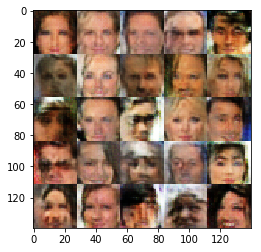

Dataset processed 163520/202599... Epoch 0/1... Discriminator Loss: 1.4281... Generator Loss: 0.5829
Dataset processed 163840/202599... Epoch 0/1... Discriminator Loss: 1.1866... Generator Loss: 1.1871
Dataset processed 164160/202599... Epoch 0/1... Discriminator Loss: 1.3568... Generator Loss: 0.5063
Dataset processed 164480/202599... Epoch 0/1... Discriminator Loss: 1.2727... Generator Loss: 0.6565
Dataset processed 164800/202599... Epoch 0/1... Discriminator Loss: 1.3558... Generator Loss: 0.7006
Dataset processed 165120/202599... Epoch 0/1... Discriminator Loss: 1.3631... Generator Loss: 0.6077
Dataset processed 165440/202599... Epoch 0/1... Discriminator Loss: 1.2527... Generator Loss: 0.6790
Dataset processed 165760/202599... Epoch 0/1... Discriminator Loss: 1.3155... Generator Loss: 0.7201
Dataset processed 166080/202599... Epoch 0/1... Discriminator Loss: 1.3946... Generator Loss: 0.6411
Dataset processed 166400/202599... Epoch 0/1... Discriminator Loss: 1.2308... Generator Los

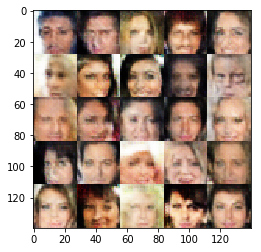

Dataset processed 166720/202599... Epoch 0/1... Discriminator Loss: 1.4202... Generator Loss: 0.5144
Dataset processed 167040/202599... Epoch 0/1... Discriminator Loss: 1.3888... Generator Loss: 0.4949
Dataset processed 167360/202599... Epoch 0/1... Discriminator Loss: 1.4077... Generator Loss: 0.7375
Dataset processed 167680/202599... Epoch 0/1... Discriminator Loss: 1.3816... Generator Loss: 0.5615
Dataset processed 168000/202599... Epoch 0/1... Discriminator Loss: 1.3917... Generator Loss: 0.5437
Dataset processed 168320/202599... Epoch 0/1... Discriminator Loss: 1.3921... Generator Loss: 0.7806
Dataset processed 168640/202599... Epoch 0/1... Discriminator Loss: 1.2845... Generator Loss: 0.5914
Dataset processed 168960/202599... Epoch 0/1... Discriminator Loss: 1.5997... Generator Loss: 0.3763
Dataset processed 169280/202599... Epoch 0/1... Discriminator Loss: 1.4149... Generator Loss: 0.4706
Dataset processed 169600/202599... Epoch 0/1... Discriminator Loss: 1.4671... Generator Los

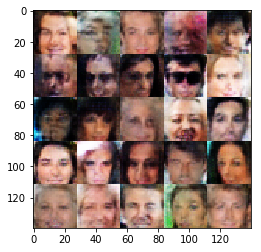

Dataset processed 169920/202599... Epoch 0/1... Discriminator Loss: 1.2876... Generator Loss: 0.6703
Dataset processed 170240/202599... Epoch 0/1... Discriminator Loss: 1.3435... Generator Loss: 0.6460
Dataset processed 170560/202599... Epoch 0/1... Discriminator Loss: 1.5852... Generator Loss: 0.4154
Dataset processed 170880/202599... Epoch 0/1... Discriminator Loss: 1.4841... Generator Loss: 0.5589
Dataset processed 171200/202599... Epoch 0/1... Discriminator Loss: 1.3543... Generator Loss: 0.6796
Dataset processed 171520/202599... Epoch 0/1... Discriminator Loss: 1.5810... Generator Loss: 0.5125
Dataset processed 171840/202599... Epoch 0/1... Discriminator Loss: 1.2575... Generator Loss: 0.5957
Dataset processed 172160/202599... Epoch 0/1... Discriminator Loss: 1.4403... Generator Loss: 0.6772
Dataset processed 172480/202599... Epoch 0/1... Discriminator Loss: 1.3911... Generator Loss: 0.6270
Dataset processed 172800/202599... Epoch 0/1... Discriminator Loss: 1.4398... Generator Los

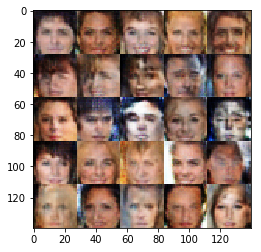

Dataset processed 173120/202599... Epoch 0/1... Discriminator Loss: 1.4953... Generator Loss: 0.4546
Dataset processed 173440/202599... Epoch 0/1... Discriminator Loss: 1.4796... Generator Loss: 0.8270
Dataset processed 173760/202599... Epoch 0/1... Discriminator Loss: 1.5546... Generator Loss: 0.5774
Dataset processed 174080/202599... Epoch 0/1... Discriminator Loss: 1.2146... Generator Loss: 0.5878
Dataset processed 174400/202599... Epoch 0/1... Discriminator Loss: 1.5692... Generator Loss: 0.4108
Dataset processed 174720/202599... Epoch 0/1... Discriminator Loss: 1.2031... Generator Loss: 0.6727
Dataset processed 175040/202599... Epoch 0/1... Discriminator Loss: 1.4092... Generator Loss: 0.7537
Dataset processed 175360/202599... Epoch 0/1... Discriminator Loss: 1.3810... Generator Loss: 0.6850
Dataset processed 175680/202599... Epoch 0/1... Discriminator Loss: 1.3948... Generator Loss: 0.6027
Dataset processed 176000/202599... Epoch 0/1... Discriminator Loss: 1.5671... Generator Los

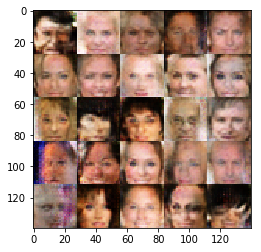

Dataset processed 176320/202599... Epoch 0/1... Discriminator Loss: 1.5429... Generator Loss: 0.6695
Dataset processed 176640/202599... Epoch 0/1... Discriminator Loss: 1.4700... Generator Loss: 0.5595
Dataset processed 176960/202599... Epoch 0/1... Discriminator Loss: 1.3851... Generator Loss: 0.6439
Dataset processed 177280/202599... Epoch 0/1... Discriminator Loss: 1.2220... Generator Loss: 0.5671
Dataset processed 177600/202599... Epoch 0/1... Discriminator Loss: 1.2730... Generator Loss: 0.8087
Dataset processed 177920/202599... Epoch 0/1... Discriminator Loss: 1.3254... Generator Loss: 0.5626
Dataset processed 178240/202599... Epoch 0/1... Discriminator Loss: 1.2439... Generator Loss: 0.6054
Dataset processed 178560/202599... Epoch 0/1... Discriminator Loss: 1.2821... Generator Loss: 0.6006
Dataset processed 178880/202599... Epoch 0/1... Discriminator Loss: 1.4565... Generator Loss: 0.4824
Dataset processed 179200/202599... Epoch 0/1... Discriminator Loss: 1.5397... Generator Los

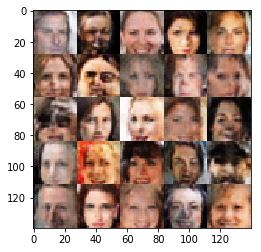

Dataset processed 179520/202599... Epoch 0/1... Discriminator Loss: 1.2925... Generator Loss: 0.6944
Dataset processed 179840/202599... Epoch 0/1... Discriminator Loss: 1.4346... Generator Loss: 0.6755
Dataset processed 180160/202599... Epoch 0/1... Discriminator Loss: 1.4236... Generator Loss: 0.6139
Dataset processed 180480/202599... Epoch 0/1... Discriminator Loss: 1.5697... Generator Loss: 0.5496
Dataset processed 180800/202599... Epoch 0/1... Discriminator Loss: 1.5461... Generator Loss: 0.3586
Dataset processed 181120/202599... Epoch 0/1... Discriminator Loss: 1.4306... Generator Loss: 0.6100
Dataset processed 181440/202599... Epoch 0/1... Discriminator Loss: 1.2849... Generator Loss: 0.6333
Dataset processed 181760/202599... Epoch 0/1... Discriminator Loss: 1.4626... Generator Loss: 0.6138
Dataset processed 182080/202599... Epoch 0/1... Discriminator Loss: 1.3951... Generator Loss: 0.7314
Dataset processed 182400/202599... Epoch 0/1... Discriminator Loss: 1.4008... Generator Los

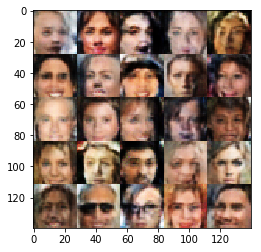

Dataset processed 182720/202599... Epoch 0/1... Discriminator Loss: 1.2800... Generator Loss: 0.8595
Dataset processed 183040/202599... Epoch 0/1... Discriminator Loss: 1.3645... Generator Loss: 0.6947
Dataset processed 183360/202599... Epoch 0/1... Discriminator Loss: 1.5199... Generator Loss: 0.4707
Dataset processed 183680/202599... Epoch 0/1... Discriminator Loss: 1.2782... Generator Loss: 0.9309
Dataset processed 184000/202599... Epoch 0/1... Discriminator Loss: 1.4658... Generator Loss: 0.6240
Dataset processed 184320/202599... Epoch 0/1... Discriminator Loss: 1.4991... Generator Loss: 0.6339
Dataset processed 184640/202599... Epoch 0/1... Discriminator Loss: 1.3359... Generator Loss: 0.5575
Dataset processed 184960/202599... Epoch 0/1... Discriminator Loss: 1.4440... Generator Loss: 0.7587
Dataset processed 185280/202599... Epoch 0/1... Discriminator Loss: 1.4612... Generator Loss: 0.4628
Dataset processed 185600/202599... Epoch 0/1... Discriminator Loss: 1.2286... Generator Los

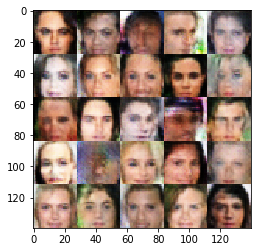

Dataset processed 185920/202599... Epoch 0/1... Discriminator Loss: 1.5467... Generator Loss: 0.4732
Dataset processed 186240/202599... Epoch 0/1... Discriminator Loss: 1.4975... Generator Loss: 0.4706
Dataset processed 186560/202599... Epoch 0/1... Discriminator Loss: 1.5299... Generator Loss: 0.5189
Dataset processed 186880/202599... Epoch 0/1... Discriminator Loss: 1.3441... Generator Loss: 0.5148
Dataset processed 187200/202599... Epoch 0/1... Discriminator Loss: 1.3296... Generator Loss: 0.8175
Dataset processed 187520/202599... Epoch 0/1... Discriminator Loss: 1.4100... Generator Loss: 0.6471
Dataset processed 187840/202599... Epoch 0/1... Discriminator Loss: 1.3744... Generator Loss: 0.5613
Dataset processed 188160/202599... Epoch 0/1... Discriminator Loss: 1.3220... Generator Loss: 0.6239
Dataset processed 188480/202599... Epoch 0/1... Discriminator Loss: 1.4703... Generator Loss: 0.6043
Dataset processed 188800/202599... Epoch 0/1... Discriminator Loss: 1.3246... Generator Los

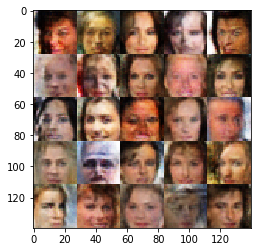

Dataset processed 189120/202599... Epoch 0/1... Discriminator Loss: 1.2682... Generator Loss: 0.7466
Dataset processed 189440/202599... Epoch 0/1... Discriminator Loss: 1.4030... Generator Loss: 0.6670
Dataset processed 189760/202599... Epoch 0/1... Discriminator Loss: 1.3225... Generator Loss: 0.5682
Dataset processed 190080/202599... Epoch 0/1... Discriminator Loss: 1.4938... Generator Loss: 0.5699
Dataset processed 190400/202599... Epoch 0/1... Discriminator Loss: 1.4133... Generator Loss: 0.5149
Dataset processed 190720/202599... Epoch 0/1... Discriminator Loss: 1.4247... Generator Loss: 0.5588
Dataset processed 191040/202599... Epoch 0/1... Discriminator Loss: 1.3621... Generator Loss: 0.7916
Dataset processed 191360/202599... Epoch 0/1... Discriminator Loss: 1.2996... Generator Loss: 0.7101
Dataset processed 191680/202599... Epoch 0/1... Discriminator Loss: 1.1116... Generator Loss: 0.5770
Dataset processed 192000/202599... Epoch 0/1... Discriminator Loss: 1.5013... Generator Los

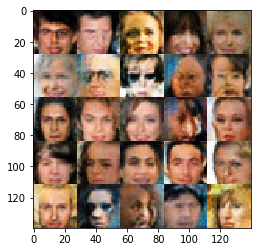

Dataset processed 192320/202599... Epoch 0/1... Discriminator Loss: 1.3900... Generator Loss: 0.6617
Dataset processed 192640/202599... Epoch 0/1... Discriminator Loss: 1.4367... Generator Loss: 0.5762
Dataset processed 192960/202599... Epoch 0/1... Discriminator Loss: 1.3685... Generator Loss: 0.6037
Dataset processed 193280/202599... Epoch 0/1... Discriminator Loss: 1.2606... Generator Loss: 1.0774
Dataset processed 193600/202599... Epoch 0/1... Discriminator Loss: 1.3142... Generator Loss: 0.8015
Dataset processed 193920/202599... Epoch 0/1... Discriminator Loss: 1.6799... Generator Loss: 0.4870
Dataset processed 194240/202599... Epoch 0/1... Discriminator Loss: 1.3474... Generator Loss: 0.6189
Dataset processed 194560/202599... Epoch 0/1... Discriminator Loss: 1.3488... Generator Loss: 0.6686
Dataset processed 194880/202599... Epoch 0/1... Discriminator Loss: 1.3835... Generator Loss: 0.5937
Dataset processed 195200/202599... Epoch 0/1... Discriminator Loss: 1.2170... Generator Los

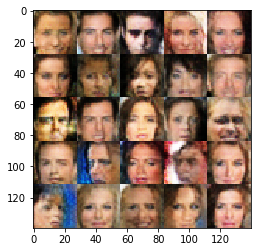

Dataset processed 195520/202599... Epoch 0/1... Discriminator Loss: 1.2880... Generator Loss: 0.5462
Dataset processed 195840/202599... Epoch 0/1... Discriminator Loss: 1.3726... Generator Loss: 0.7396
Dataset processed 196160/202599... Epoch 0/1... Discriminator Loss: 1.3303... Generator Loss: 0.6292
Dataset processed 196480/202599... Epoch 0/1... Discriminator Loss: 1.3589... Generator Loss: 0.5506
Dataset processed 196800/202599... Epoch 0/1... Discriminator Loss: 1.4873... Generator Loss: 0.5679
Dataset processed 197120/202599... Epoch 0/1... Discriminator Loss: 1.3956... Generator Loss: 0.6751
Dataset processed 197440/202599... Epoch 0/1... Discriminator Loss: 1.4645... Generator Loss: 0.4587
Dataset processed 197760/202599... Epoch 0/1... Discriminator Loss: 1.2987... Generator Loss: 0.8514
Dataset processed 198080/202599... Epoch 0/1... Discriminator Loss: 1.1901... Generator Loss: 0.6648
Dataset processed 198400/202599... Epoch 0/1... Discriminator Loss: 1.4361... Generator Los

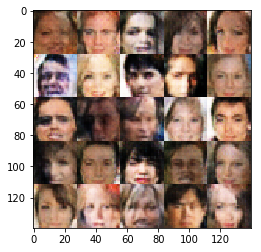

Dataset processed 198720/202599... Epoch 0/1... Discriminator Loss: 1.4211... Generator Loss: 0.5800
Dataset processed 199040/202599... Epoch 0/1... Discriminator Loss: 1.3794... Generator Loss: 0.6677
Dataset processed 199360/202599... Epoch 0/1... Discriminator Loss: 1.5523... Generator Loss: 0.6002
Dataset processed 199680/202599... Epoch 0/1... Discriminator Loss: 1.3197... Generator Loss: 0.5772
Dataset processed 200000/202599... Epoch 0/1... Discriminator Loss: 1.3503... Generator Loss: 0.7038
Dataset processed 200320/202599... Epoch 0/1... Discriminator Loss: 1.3931... Generator Loss: 0.6244
Dataset processed 200640/202599... Epoch 0/1... Discriminator Loss: 1.3207... Generator Loss: 0.5994
Dataset processed 200960/202599... Epoch 0/1... Discriminator Loss: 1.3290... Generator Loss: 0.6250
Dataset processed 201280/202599... Epoch 0/1... Discriminator Loss: 1.3587... Generator Loss: 0.7562
Dataset processed 201600/202599... Epoch 0/1... Discriminator Loss: 1.4299... Generator Los

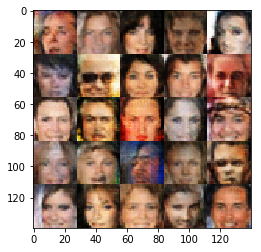

Dataset processed 201920/202599... Epoch 0/1... Discriminator Loss: 1.4993... Generator Loss: 0.5660
Dataset processed 202240/202599... Epoch 0/1... Discriminator Loss: 1.3782... Generator Loss: 0.5718
Dataset processed 202560/202599... Epoch 0/1... Discriminator Loss: 1.3184... Generator Loss: 0.6560


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1
alpha = 0.01
smooth = 0.05

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha, smooth)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.